# CFD -- 2D Advection-Diffusion Equation
## Kelsey Malloy

### <i>last edited: 09/2020</i>

In [1]:
import numpy as np
import numpy.linalg as LA
import matplotlib as mpl
import matplotlib.pyplot as plt

### Functions

In [20]:
def gradientx(u,dx,order):
    # assume periodicity
    
    ux = np.zeros(u.shape)
    
    if order == 1: # FORWARD EULER
        ux[:,:-1] = (u[:,1:] - u[:,:-1])/dx
        
        ux[:,-1] = ux[:,0] # periodic
    
    elif order == -1: # BACKWARD EULER
        ux[:,1:] = (u[:,1:] - u[:,:-1])/dx
        
        ux[:,0] = ux[:,-1]
        
#     elif order == 2: # CENTERED DIFF, 2nd order
#         ux[1:-1] = (u[2:]-u[:-2]) / (2*dx)       
#         ux[0] = (u[1]-u[-2]) / (2*dx) 
#         ux[-1] = (u[1]-u[-2]) / (2*dx)
        
    return ux

In [21]:
def gradienty(u,dy,order):
    # assume periodicity
    
    uy = np.zeros(u.shape)
    
    if order == 1: # FORWARD EULER
        uy[:-1,:] = (u[1:,:] - u[:-1,:])/dy
        
        uy[:,-1] = uy[:,0] # periodic
    
    elif order == -1: # BACKWARD EULER
        uy[1:,:] = (u[1:,:] - u[:-1,:])/dy
        
        uy[0,:] = uy[-1,:]
        
#     elif order == 2: # CENTERED DIFF, 2nd order
#         ux[1:-1] = (u[2:]-u[:-2]) / (2*dx)       
#         ux[0] = (u[1]-u[-2]) / (2*dx) 
#         ux[-1] = (u[1]-u[-2]) / (2*dx)
        
    return uy

In [3]:
def rhsadv(q,u,v,dx,dy,order):
    # compute q at cell edges -- x-direction
    qe = np.zeros(u.shape,dtype=np.longdouble)
#     qe[:,1:] = q[:,:]
#     qe[:,0] = qe[:,-1]

    qe[:,1:-1] = 0.5*(q[:,:-1]+q[:,1:])
    qe[:,0]=0.5*(q[:,-1]+q[:,0]) 
    qe[:,-1]=0.5*(q[:,-1]+q[:,0]) 
    
    # flux along x edges
    f = u*qe
    
    # compute q at cell edges -- y-direction
    qe = np.zeros(v.shape,dtype=np.longdouble)
#     qe[1:,:] = q[:,:]
#     qe[0,:] = qe[-1,:]
    
    qe[1:-1,:] = 0.5*(q[:-1,:]+q[1:,:])
    qe[0,:]=0.5*(q[-1,:]+q[0,:]) 
    qe[-1,:]=0.5*(q[-1,:]+q[0,:]) 
    
    # flux along y edges
    g = v*qe
    
    # take divergence of f & g flux
    div = ((f[:,1:] - f[:,:-1]) / dx) + ((g[1:,:] - g[:-1,:]) / dy)

#     qx = gradientx(q,dx,order) # compute deriv
#     qy = gradienty(q,dy,order)
    r = -div
    return r

In [4]:
def rk1(q,u,v,diffusion,dx,dy,order,dt):
    r=rhsadv(q,u,v,dx,dy,order)
    q = q + dt*r
    
    return q

In [5]:
def rk3(q,u,v,diffusion,dx,dy,order,dt):
    r=rhsadv(q,u,v,dx,dy,order)
    qt = q + dt*r

    r = rhsadv(qt,u,v,dx,dy,order);
    qt = 0.75*q + 0.25*(qt + dt*r);

    r = rhsadv(qt,u,v,dx,dy,order);
    q = (q + 2.0*(qt + dt*r))/3.0;
    
    return q

In [6]:
def budget(q,dx,dy):
    return q.sum()*dx*dy

In [20]:
def plotfig(X,Y,u):
    fig = plt.figure(1,figsize=[12,12])
    ax1 = fig.add_subplot(111)
    ax1.set_title('Advection Equation Solution')
    ax1.set_xlim([-1,1])
    ax1.set_ylim([-1,1])
    ax1.contour(X,Y,u,np.linspace(0.1,1,40))
    
    return fig,ax1

In [30]:
def plotgrid(X,Y,Xc,Yc,Xu,Yu,Xv,Yv):
    fig=plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(X,Y,'k.')
    ax.plot(Xc,Yc,'ko')
    ax.plot(Xu,Yu,'rx')
    ax.plot(Xv,Yv,'b+')


In [42]:
def gauss(X,Y,xcenter,ycenter,xrad,yrad):
    return 1*(np.exp(-((X-xcenter)**2/(2*(xrad)**2) + (Y-ycenter)**2/(2*(yrad)**2))))

### Define the grid

In [35]:
xmin,xmax=-1,1
ymin,ymax=-1,1
nx,ny=256,256
dx,dy=(xmax-xmin)/nx,(ymax-ymin)/nx  # grid spacing
xpts,ypts = np.linspace(xmin,xmax,nx+1),np.linspace(ymin,ymax,ny+1) # cell edges excluding halos
print(dx,dy)
#print(xpts)
xc,yc = 0.5*(xpts[0:-1]+xpts[1:]), 0.5*(ypts[0:-1]+ypts[1:])
#print(xc)

X,Y = np.meshgrid(xpts,ypts)
Xc,Yc = np.meshgrid(xc,yc)
X,Y,Xc,Yc = np.longdouble(X),np.longdouble(Y),np.longdouble(Xc),np.longdouble(Yc)
#print(Y)

0.0078125 0.0078125


### Define the integration time & number of steps

In [36]:
mu = 0.5
c = 1.
diffusion = 0.
dt = mu*dx/c
print(dt)
nt = 2000#(xmax-xmin)/c/dt
print(nt)
order = -1

0.00390625
2000


### Time-stepping

initial conditions

0.06283183517926376354


(<Figure size 864x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x122d599b0>)

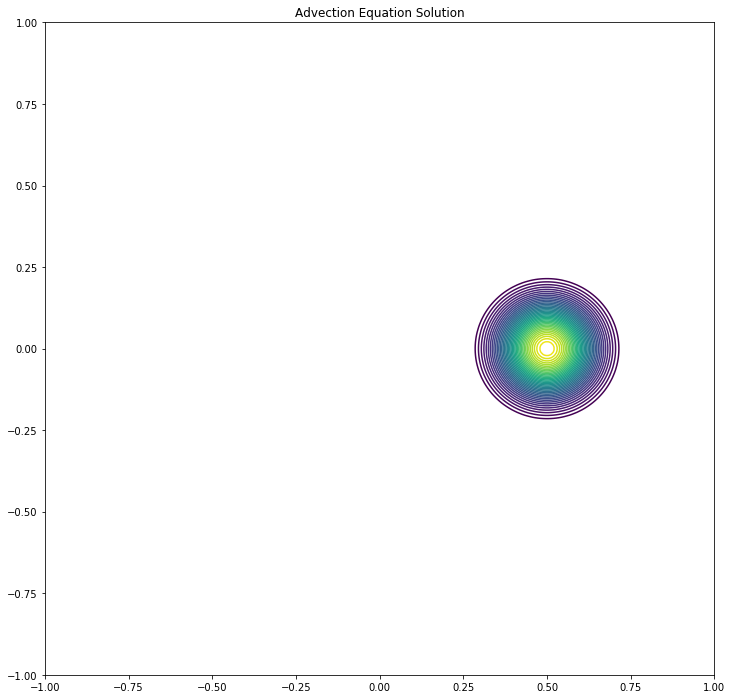

In [43]:
q = gauss(Xc,Yc,0.5,0,xrad=0.1,yrad=0.1)
bud0 = budget(q,dx,dy)
print(bud0)
plotfig(Xc,Yc,q)

In [44]:
# define u and v on C-grid
Xu,Yu = np.meshgrid(xpts,yc)
Xv,Yv = np.meshgrid(xc,ypts)
#plotgrid(X,Y,Xc,Yc,Xu,Yu,Xv,Yv)

u = -Yu
v = Xv

# u = np.ones((ny,nx+1),dtype=np.longdouble)
# v = np.ones((ny+1,nx),dtype=np.longdouble)

time updates

Budget error:  0.0 
qmin, qmax:  -6.868701459160369392e-08 0.9990470764842522935
float128


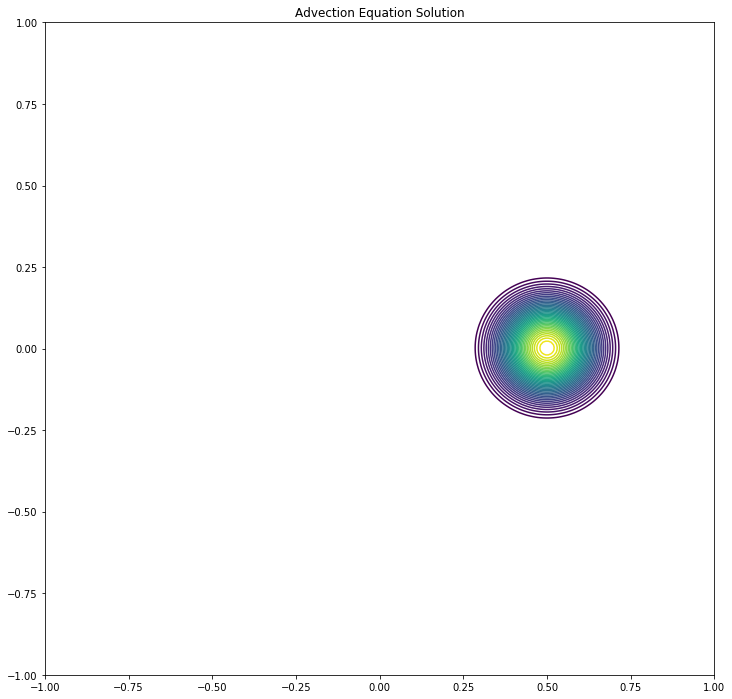

Budget error:  0.0 
qmin, qmax:  -1.2837711073709780063e-06 0.99952393973057792904
float128


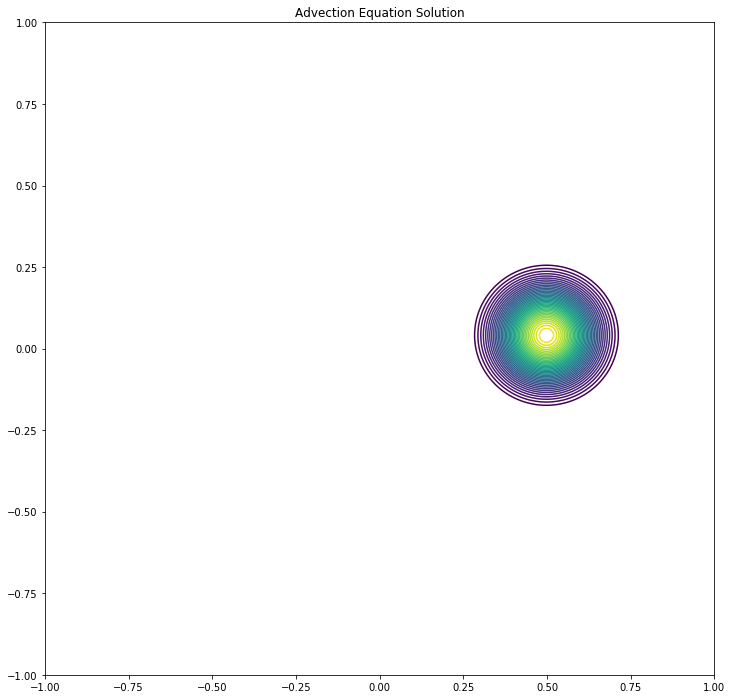

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -1.8813256752517502478e-06 0.9993748998077698459
float128


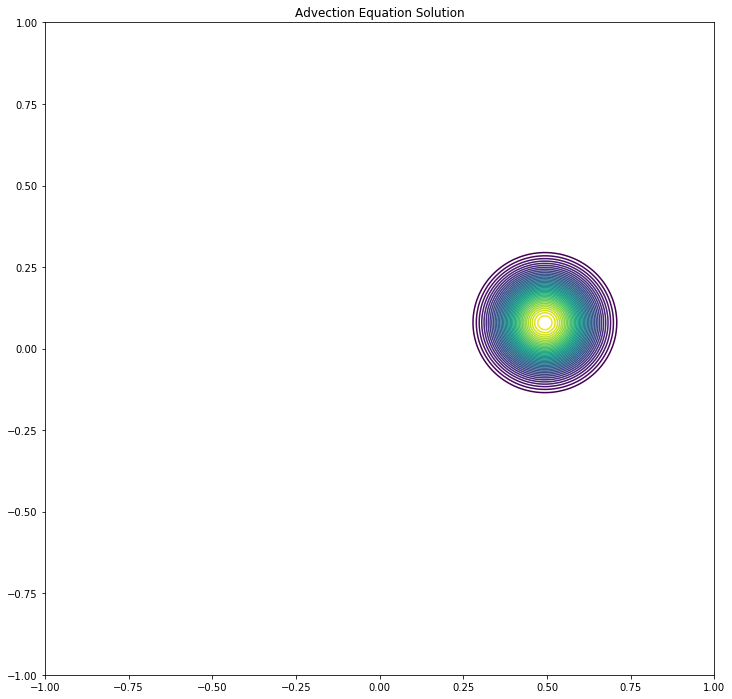

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -1.8851193444695418558e-06 0.99913680411048745193
float128


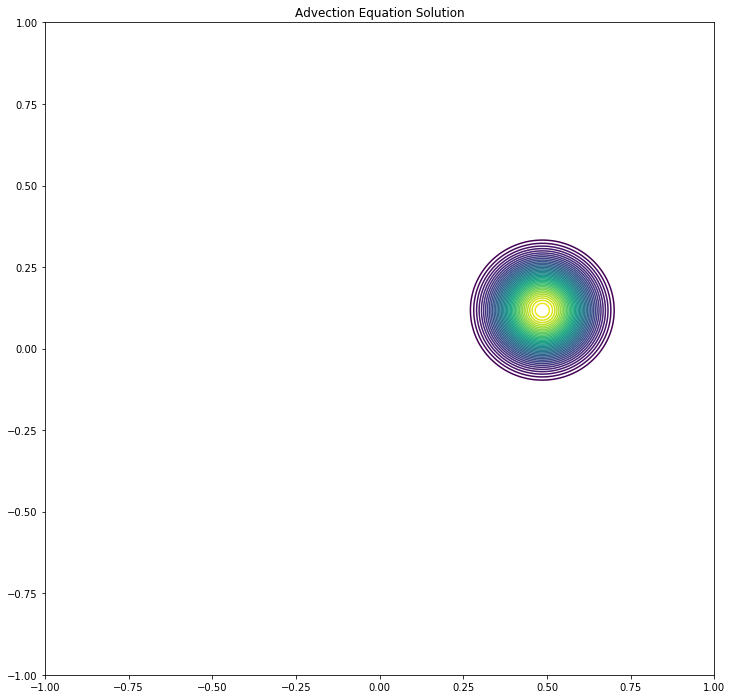

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -1.8124692499717613456e-06 0.99924916227186191386
float128


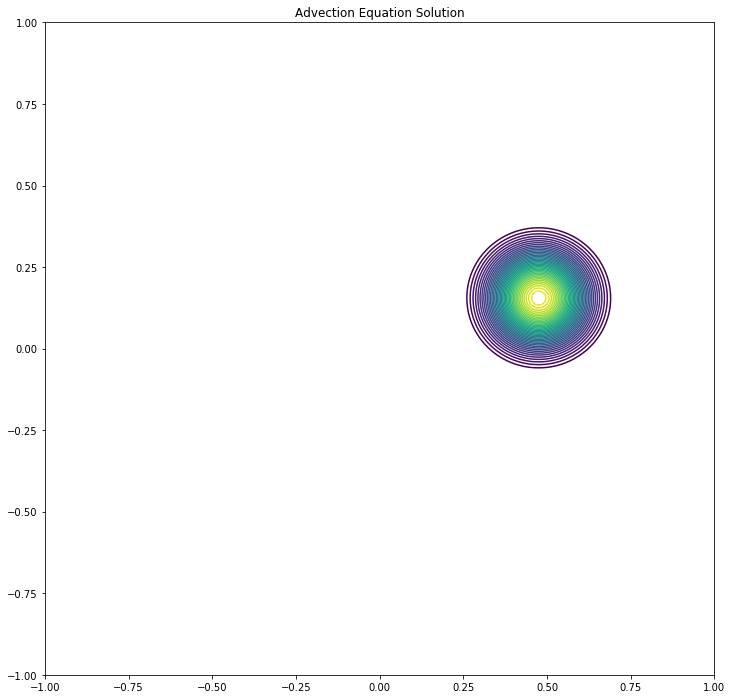

Budget error:  0.0 
qmin, qmax:  -1.2451070578180417888e-06 0.9995267279091627991
float128


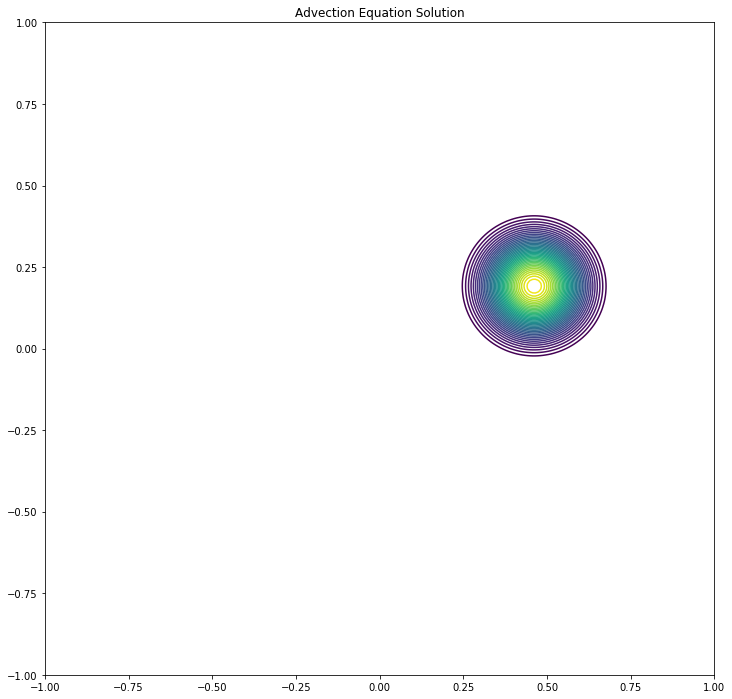

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -9.382303251009535371e-07 0.9986871509820742746
float128


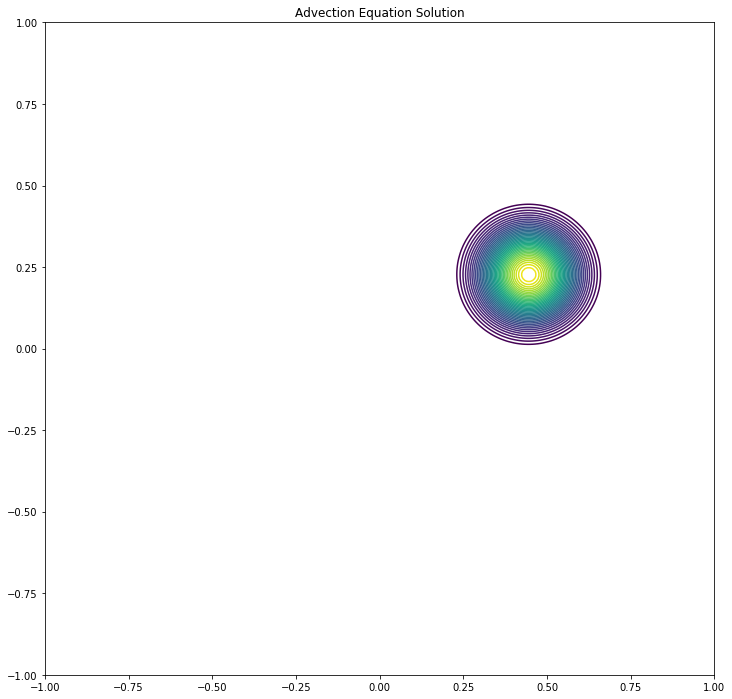

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -8.6649722548727753217e-07 0.99992177245644863013
float128


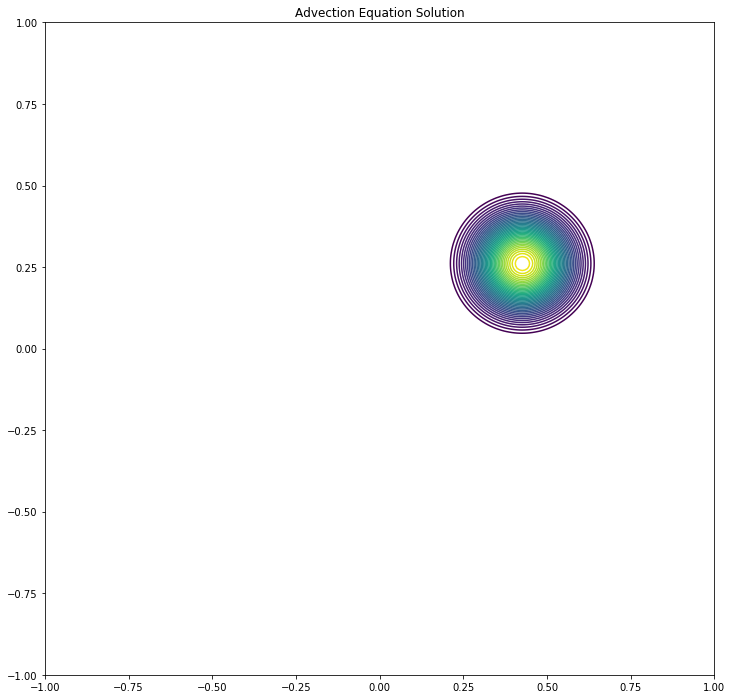

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -8.1865503802761928763e-07 0.9996362688082881891
float128


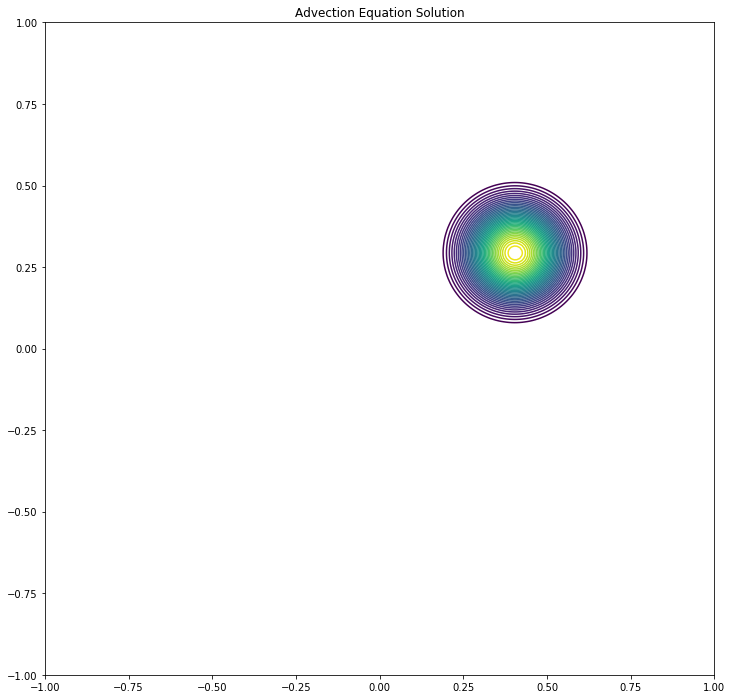

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -8.245517479608725733e-07 0.999772041829036153
float128


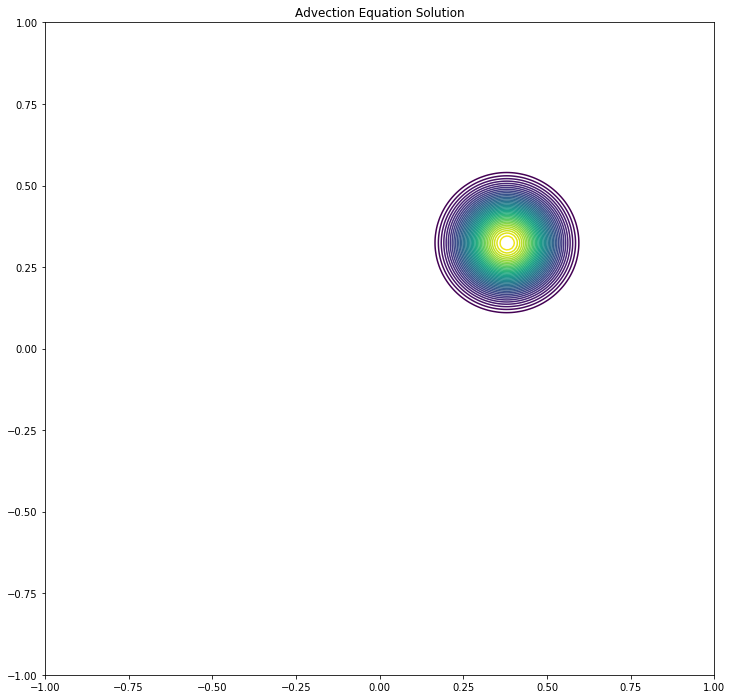

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -8.1666029380197292624e-07 0.9995015317439077291
float128


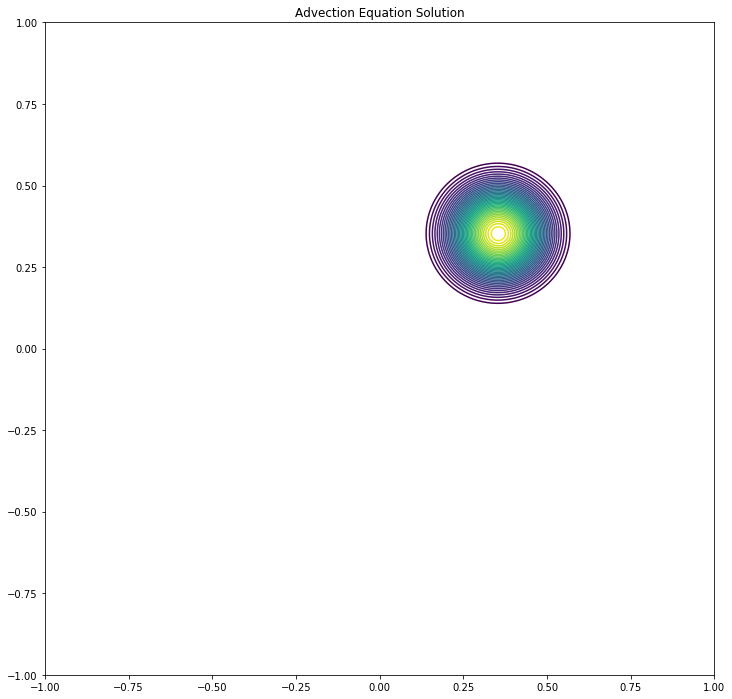

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -8.0266992089272891247e-07 0.99979196784033301087
float128


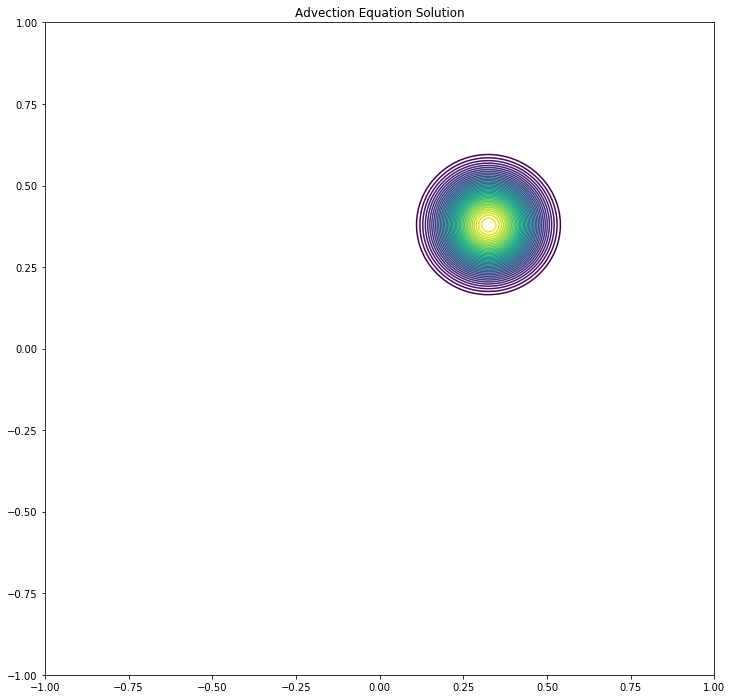

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -7.851063444582230183e-07 0.9995736054145014432
float128


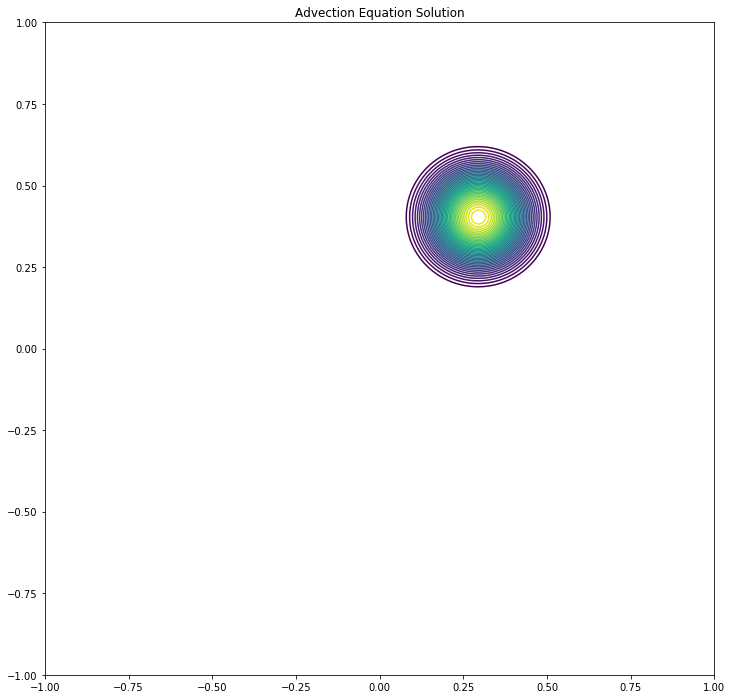

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -7.603247380287803213e-07 0.999798657277977082
float128


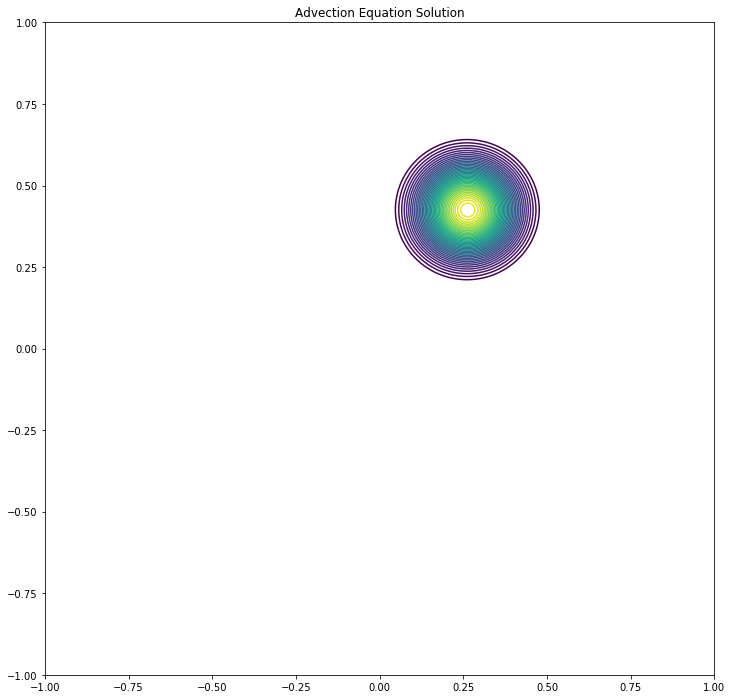

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -7.2360174621753881547e-07 0.9994370131092436551
float128


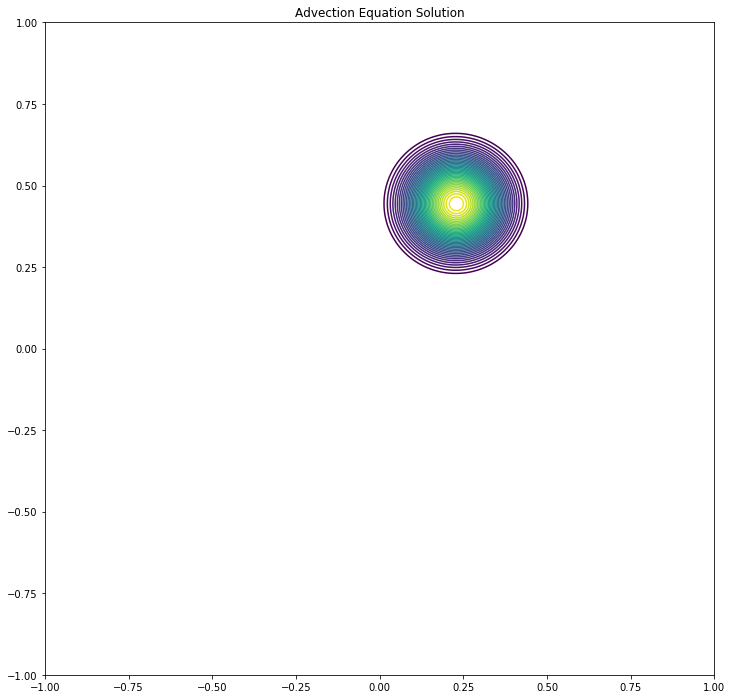

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -6.876847242996781196e-07 0.9988494547435445665
float128


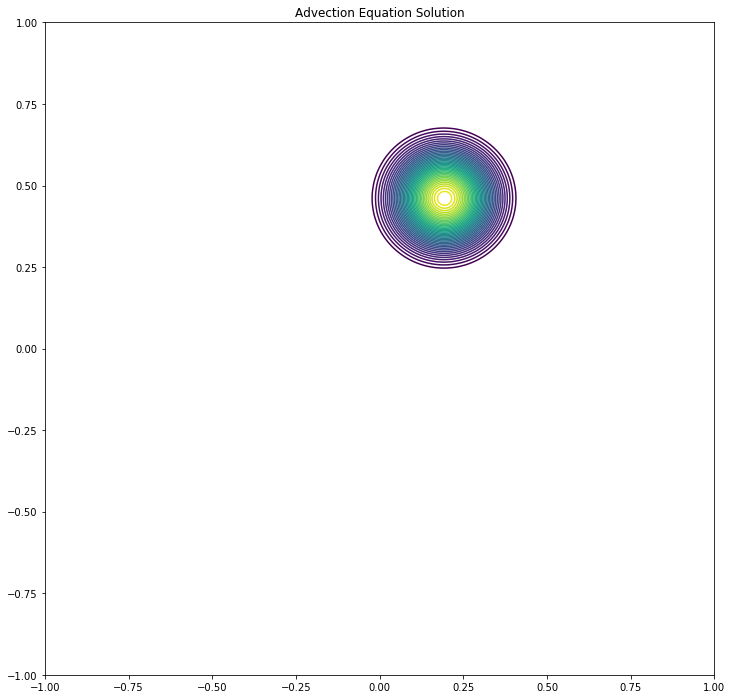

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -6.7095914455472620383e-07 0.9994093502818807635
float128


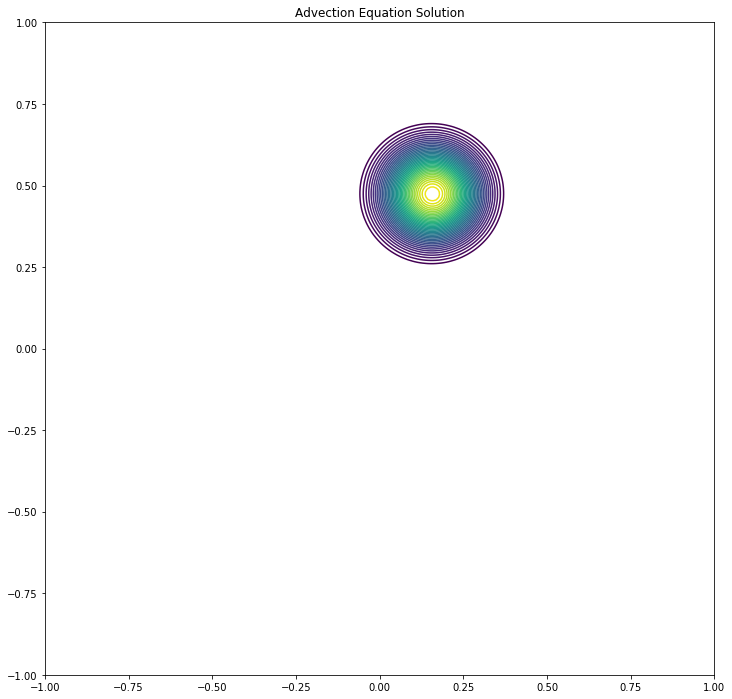

Budget error:  -1.3552527156068805425e-20 
qmin, qmax:  -8.37816649600532409e-07 0.99941646737736273415
float128


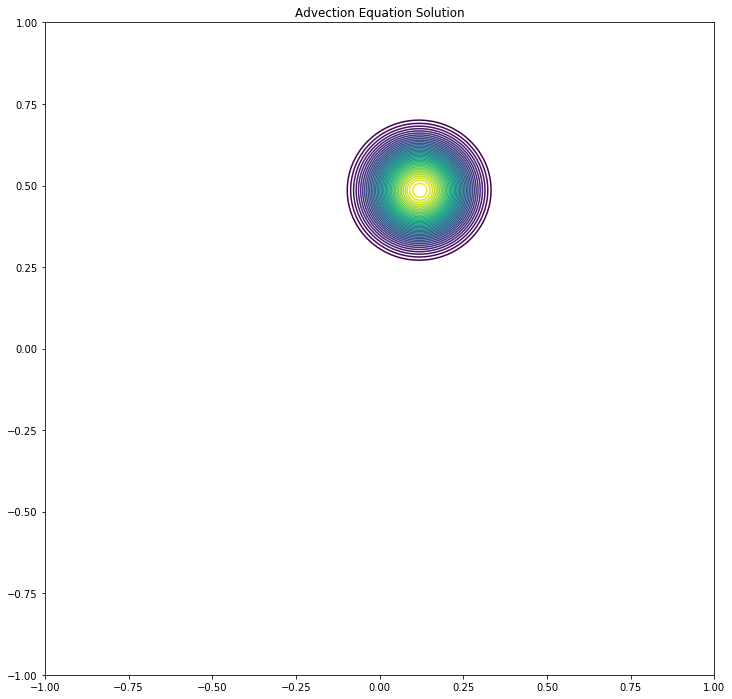

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -8.4521591782274903537e-07 0.99946260027565183003
float128


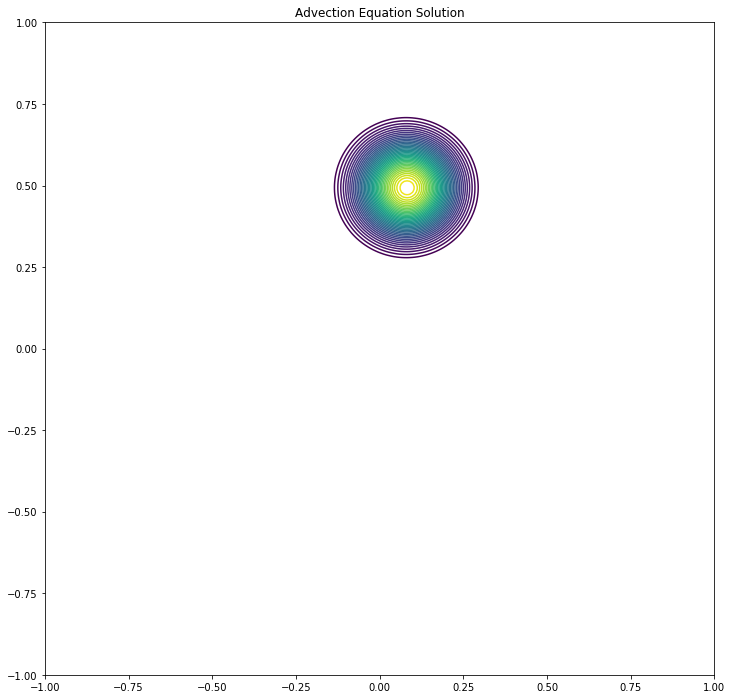

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -7.4013988696951274356e-07 0.9996503057691685165
float128


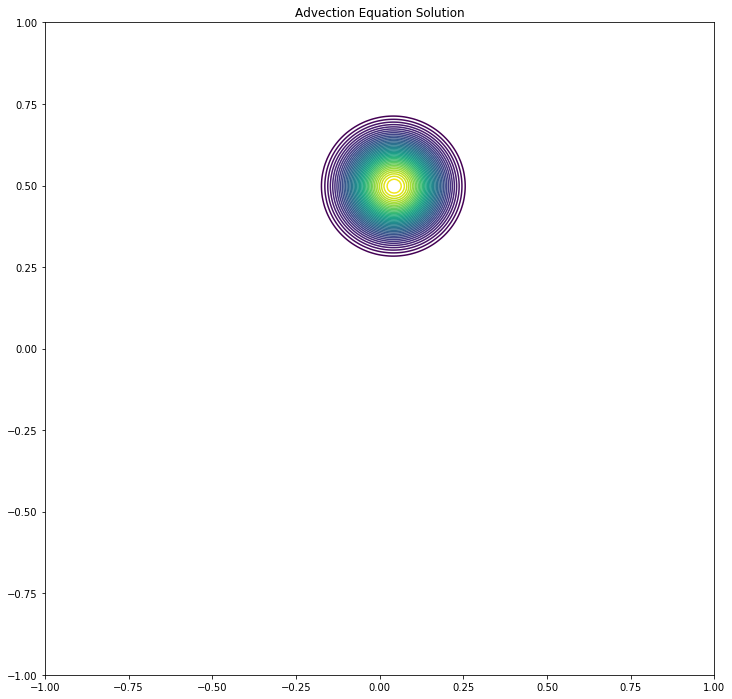

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -8.3644713318536342895e-07 0.9990751244488088975
float128


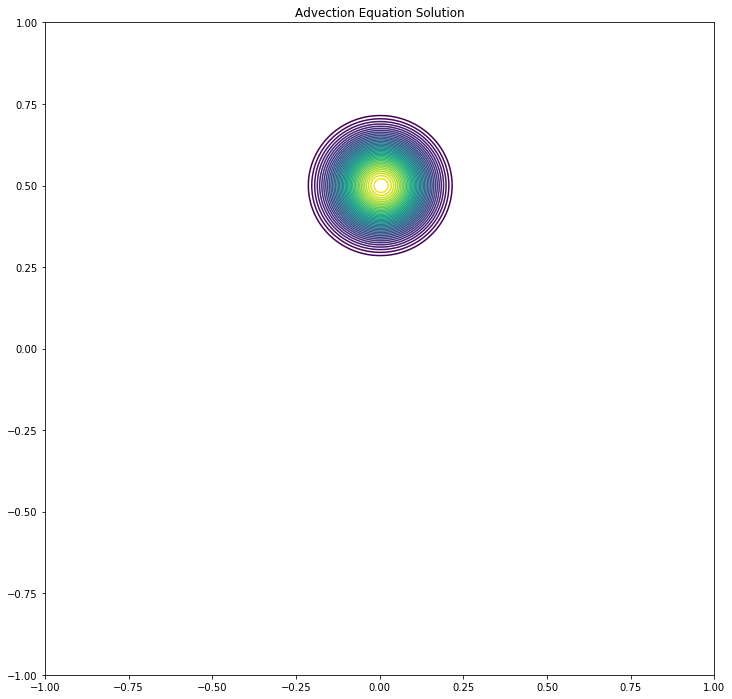

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -1.6421409224206038028e-06 0.99943194563319996275
float128


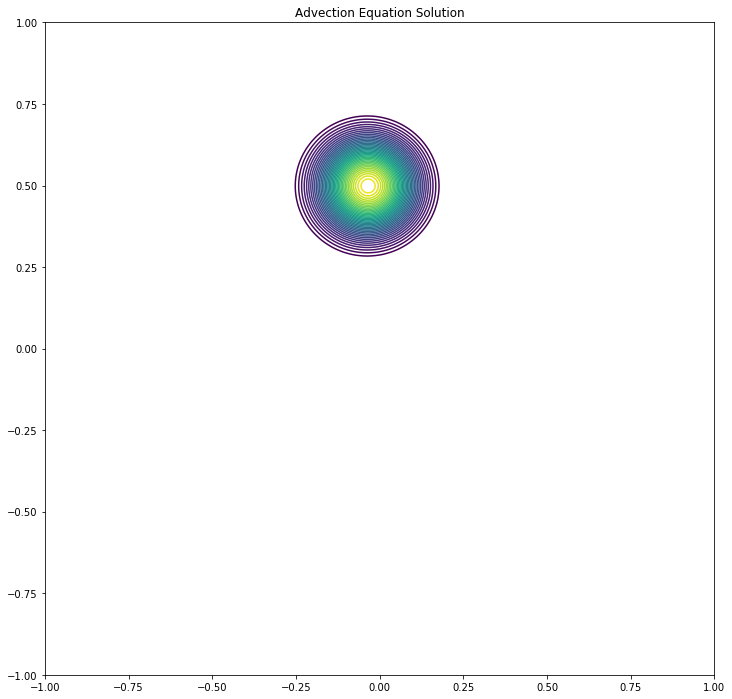

Budget error:  0.0 
qmin, qmax:  -1.9187809429521457624e-06 0.9996443801465280373
float128


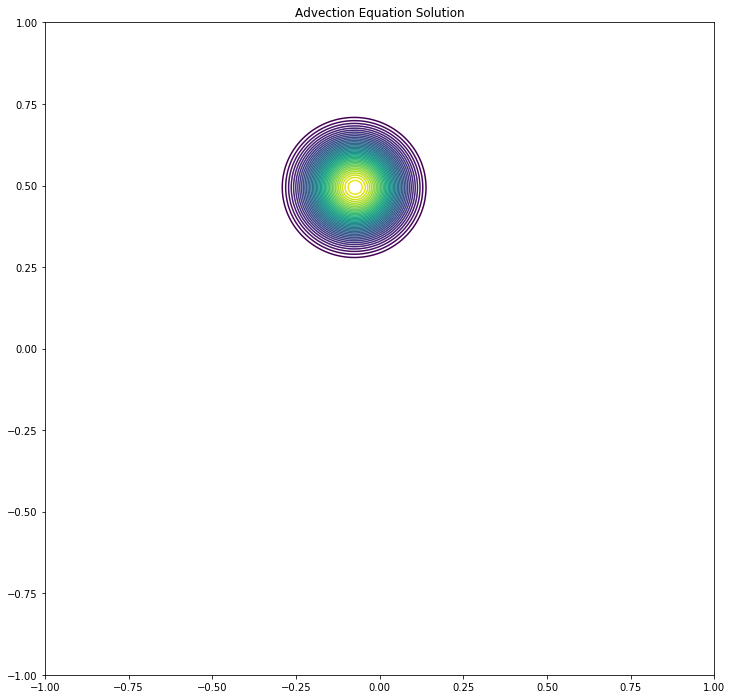

Budget error:  -1.3552527156068805425e-20 
qmin, qmax:  -1.8632907139687587466e-06 0.99957452695315562337
float128


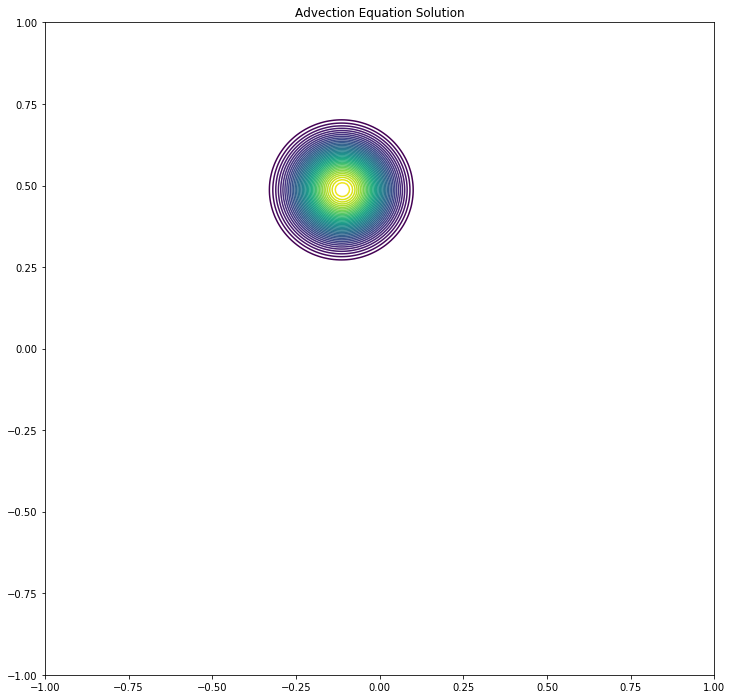

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -1.3747990336707039364e-06 0.9986952353673485567
float128


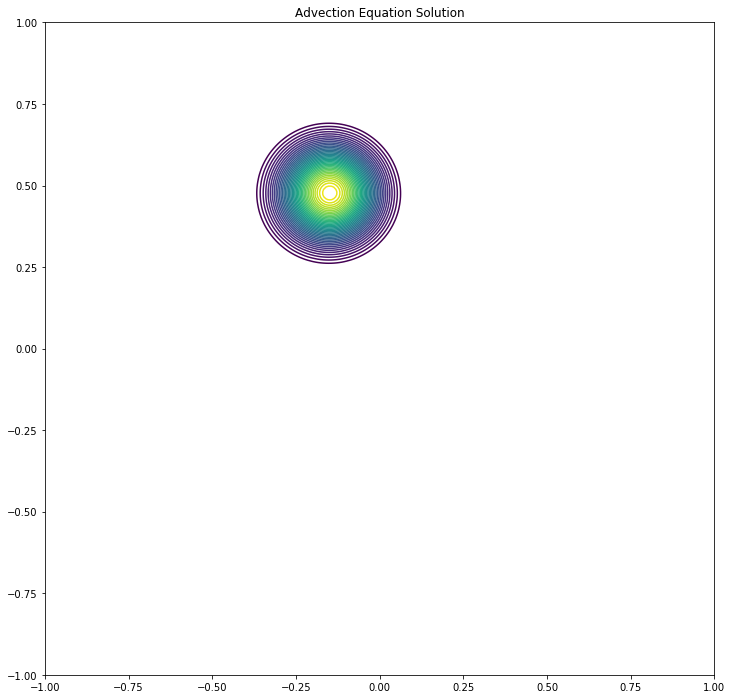

Budget error:  0.0 
qmin, qmax:  -1.0220827096732438874e-06 0.9995531268475172833
float128


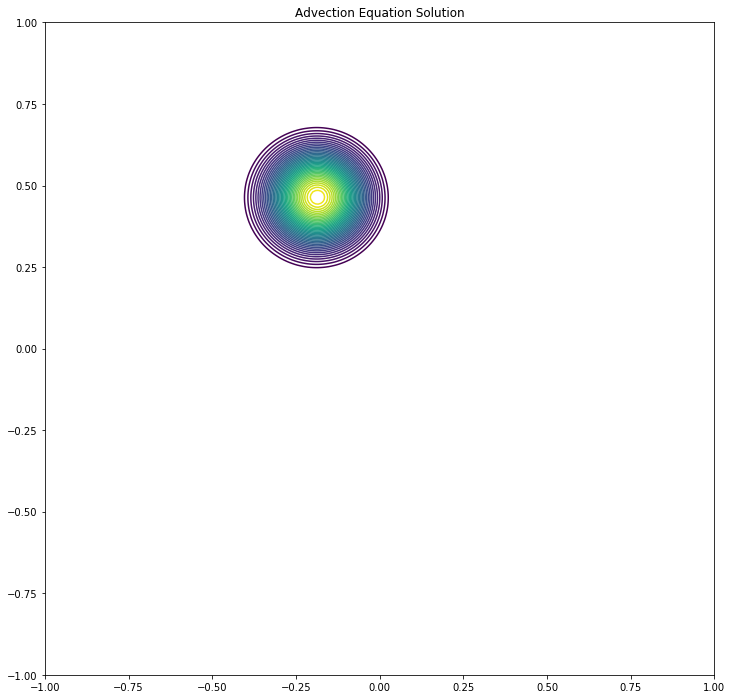

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -1.0617999802258295055e-06 0.99960367804882098593
float128


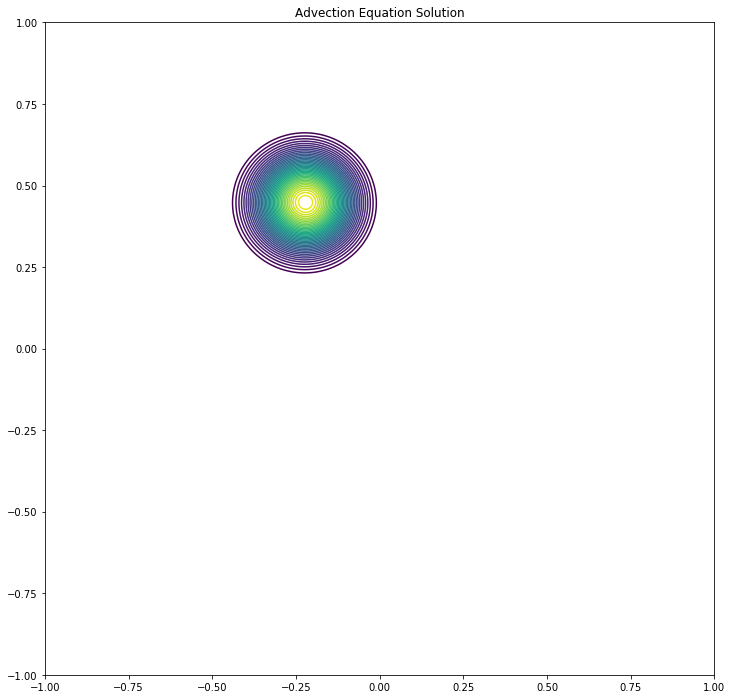

Budget error:  0.0 
qmin, qmax:  -1.2617039129566055809e-06 0.9989259368701050425
float128


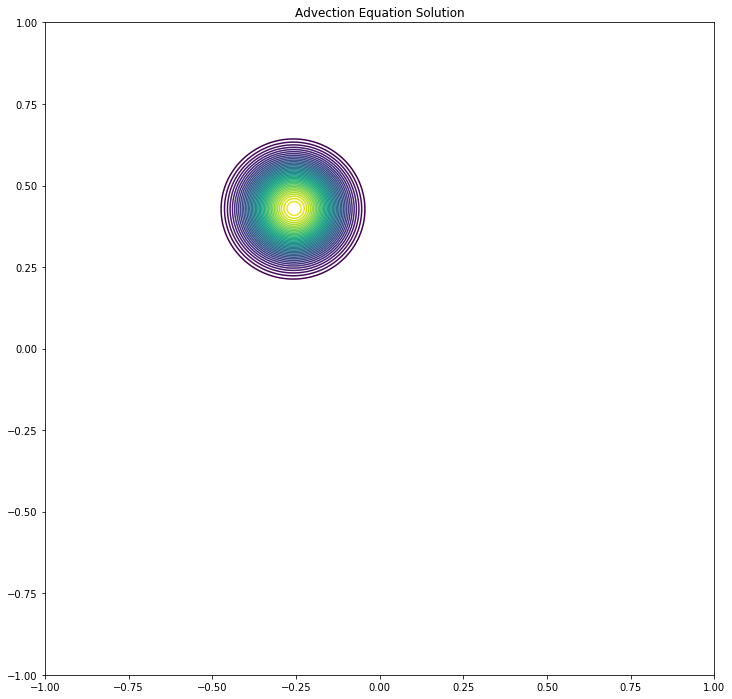

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -1.4514876918369764266e-06 0.9991849083645730324
float128


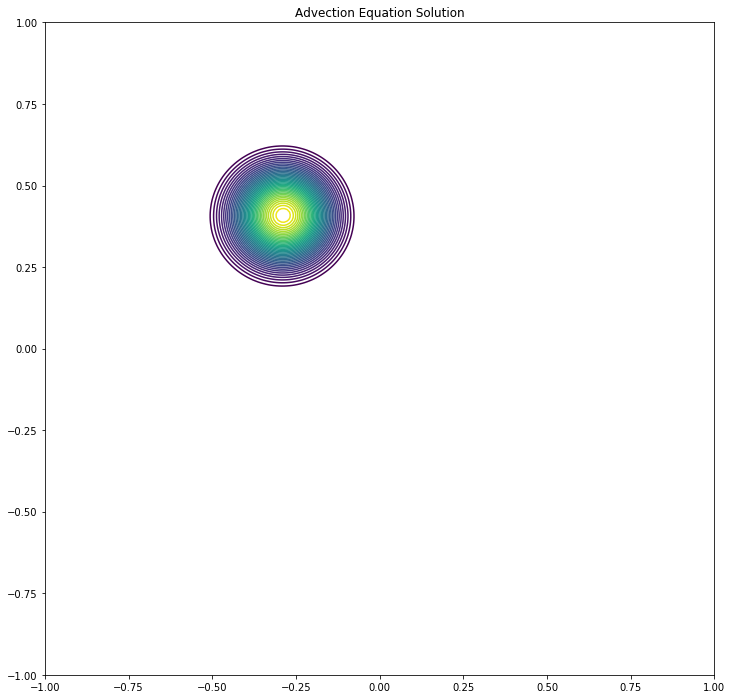

Budget error:  0.0 
qmin, qmax:  -1.5009469269471834788e-06 0.9992185566795979857
float128


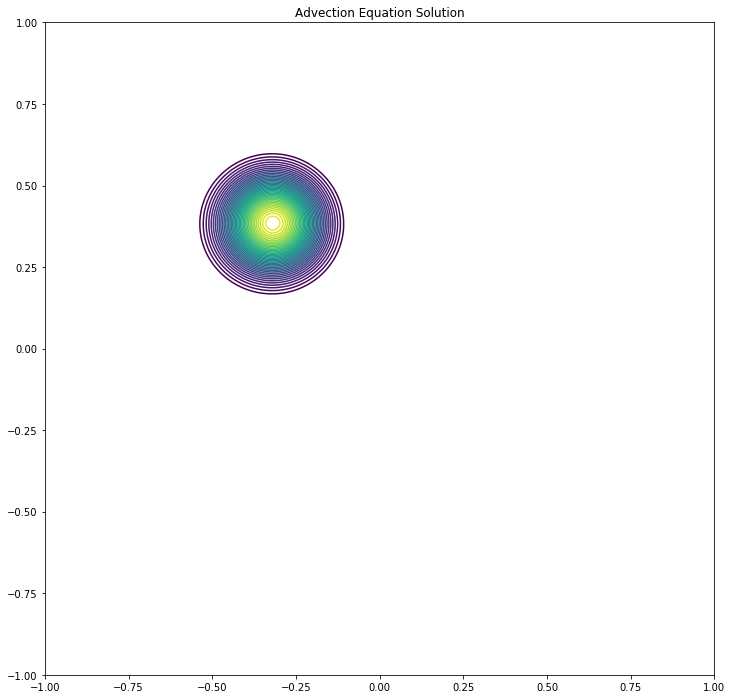

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -1.2091191159485485168e-06 0.99902134007980403457
float128


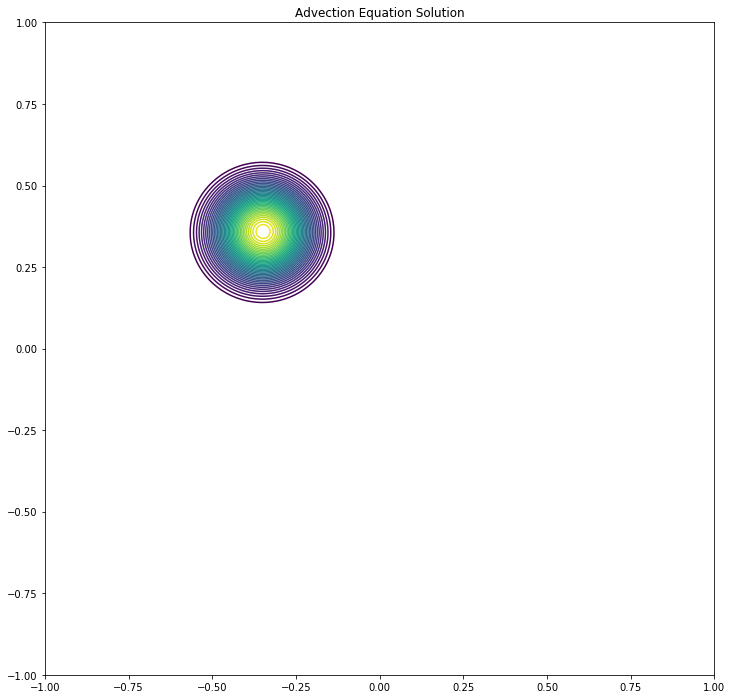

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -1.1056570900713956464e-06 0.9988775828479867047
float128


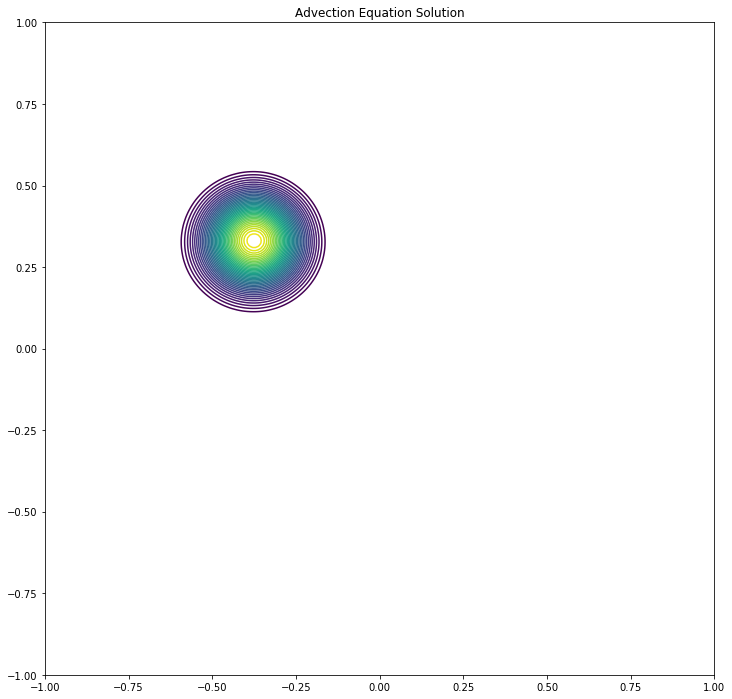

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -1.1079189004971934864e-06 0.99920438396971929446
float128


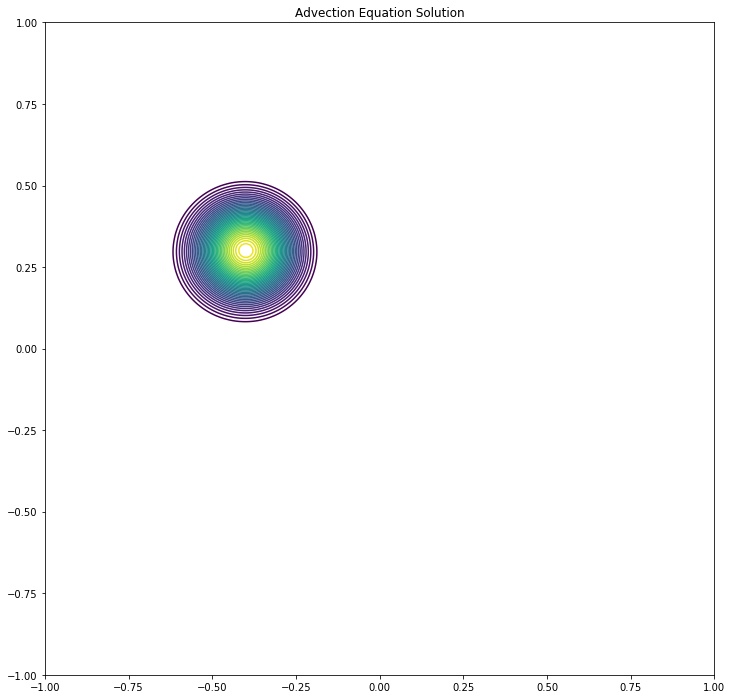

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -1.0927455403277540119e-06 0.998894530388784027
float128


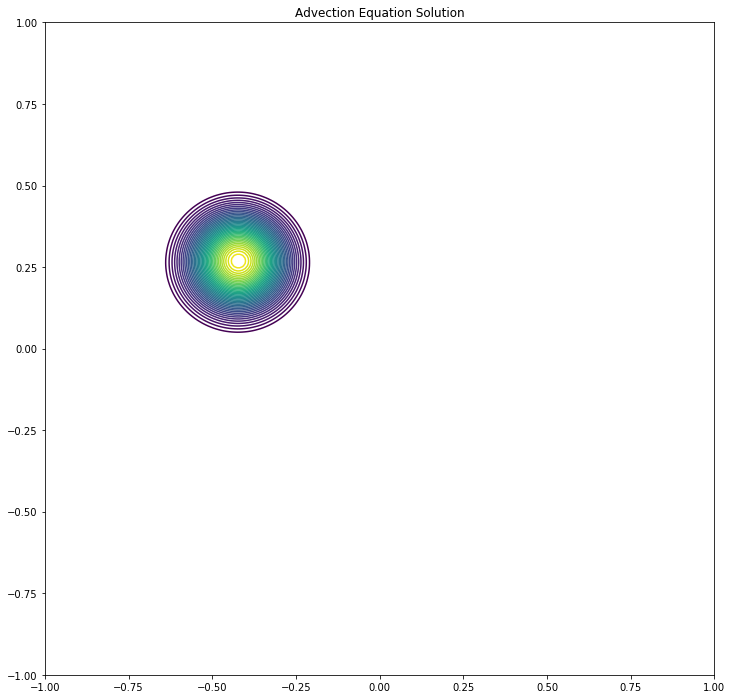

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -1.0669240377664756155e-06 0.99907071566635077906
float128


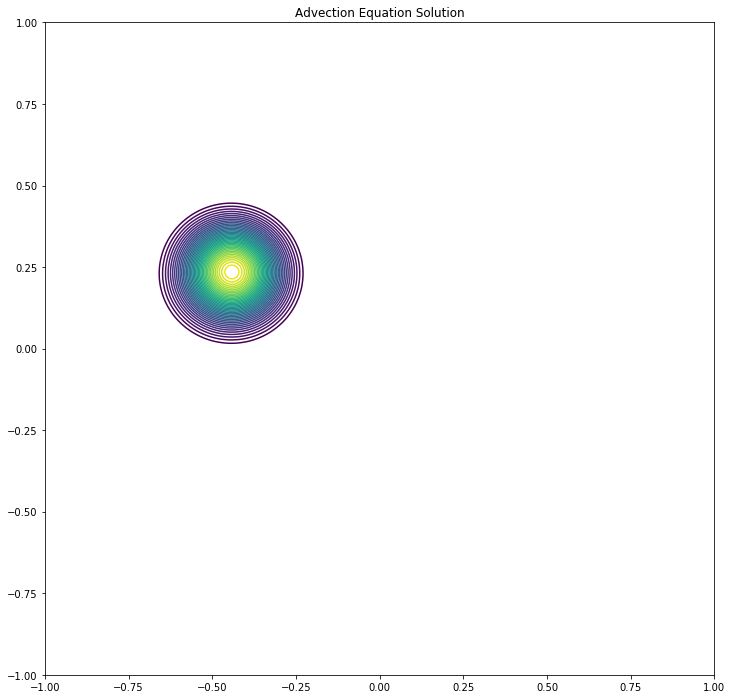

Budget error:  -1.3552527156068805425e-20 
qmin, qmax:  -1.0353284109755258096e-06 0.9994462197507792476
float128


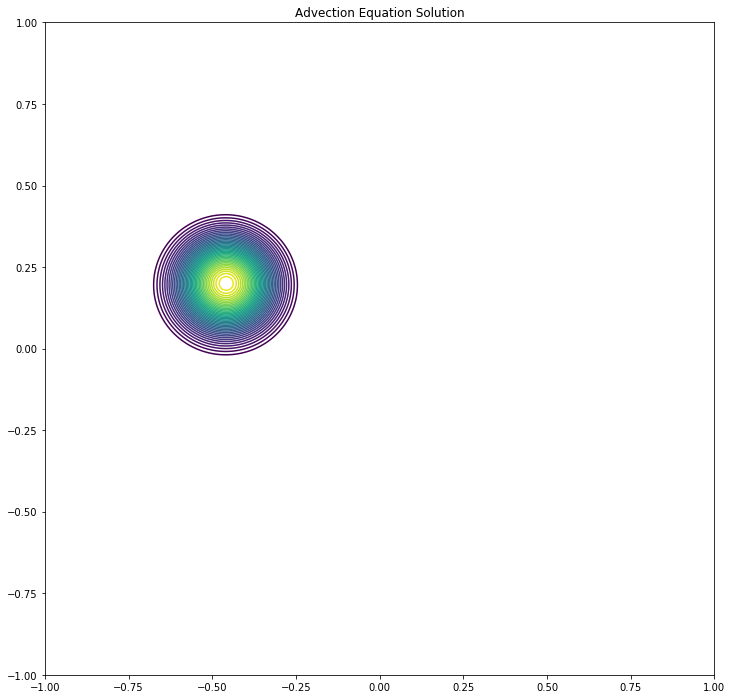

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -1.047828891779100815e-06 0.99886510856164177565
float128


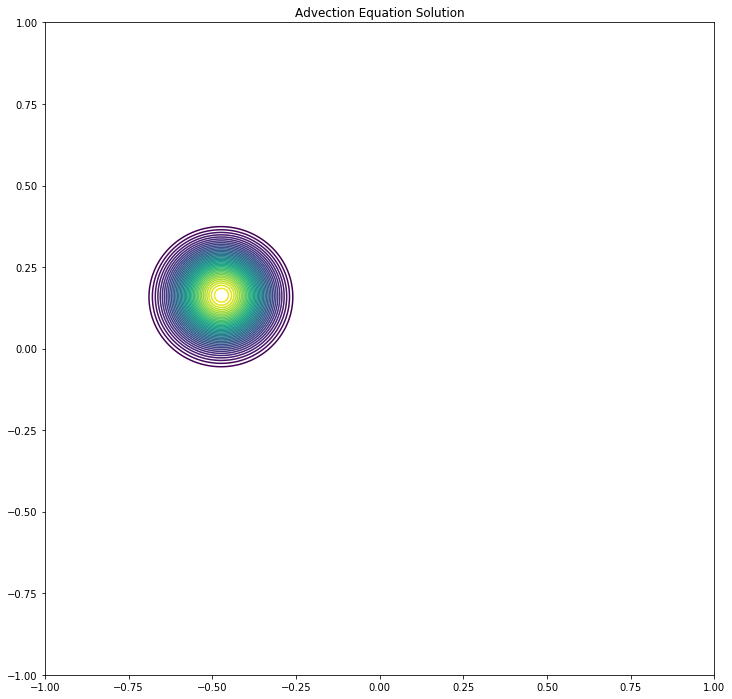

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -1.268197266428992447e-06 0.9986979915137181609
float128


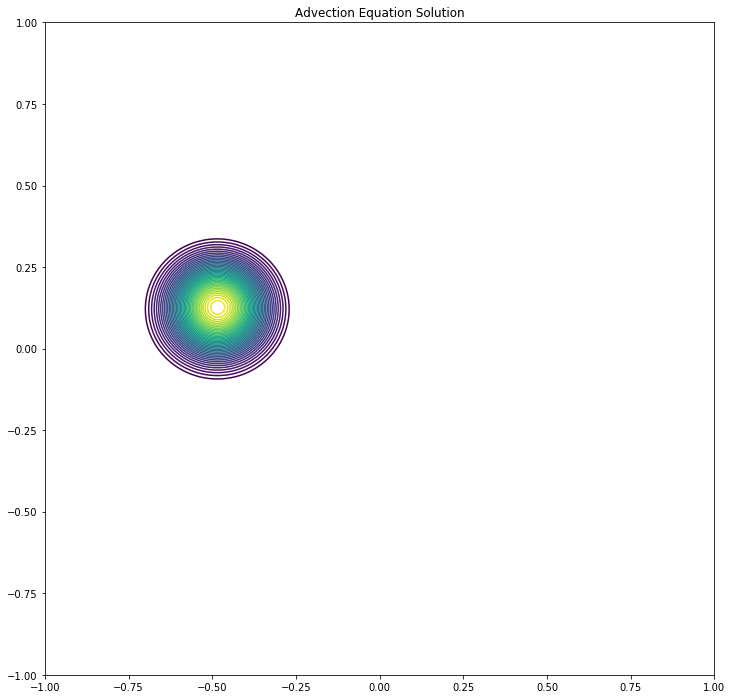

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -1.4228558513318991914e-06 0.9986640986331158437
float128


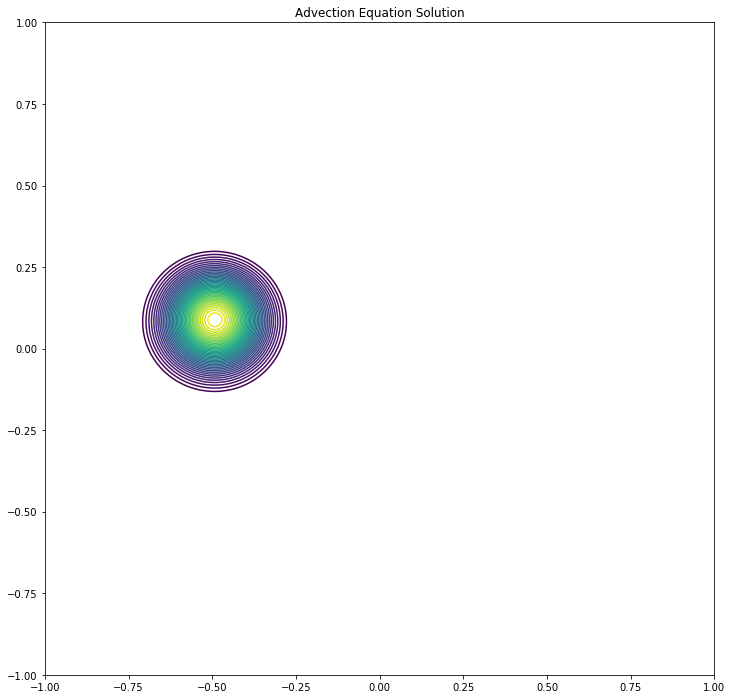

Budget error:  -1.3552527156068805425e-20 
qmin, qmax:  -1.3530014731338111539e-06 0.9993191918105960281
float128


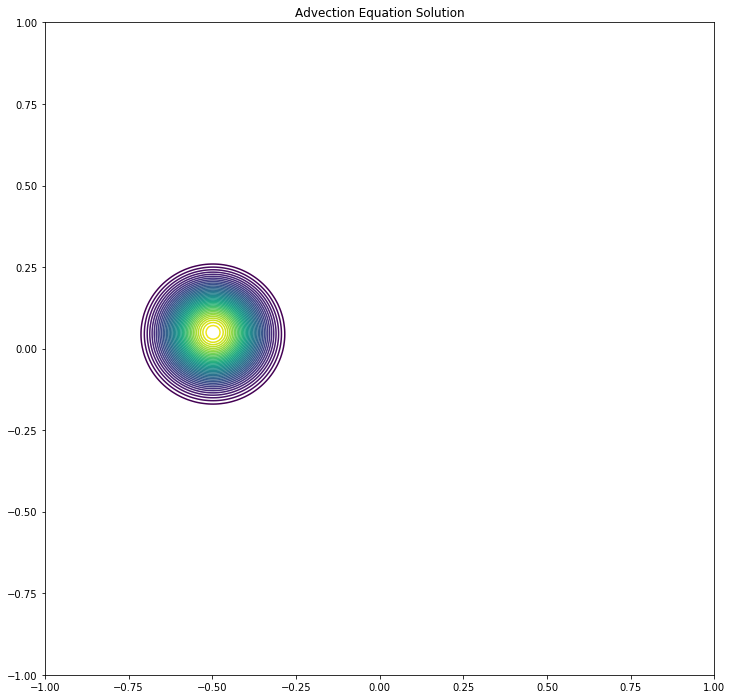

Budget error:  0.0 
qmin, qmax:  -1.1354862472234112138e-06 0.9986926758481141271
float128


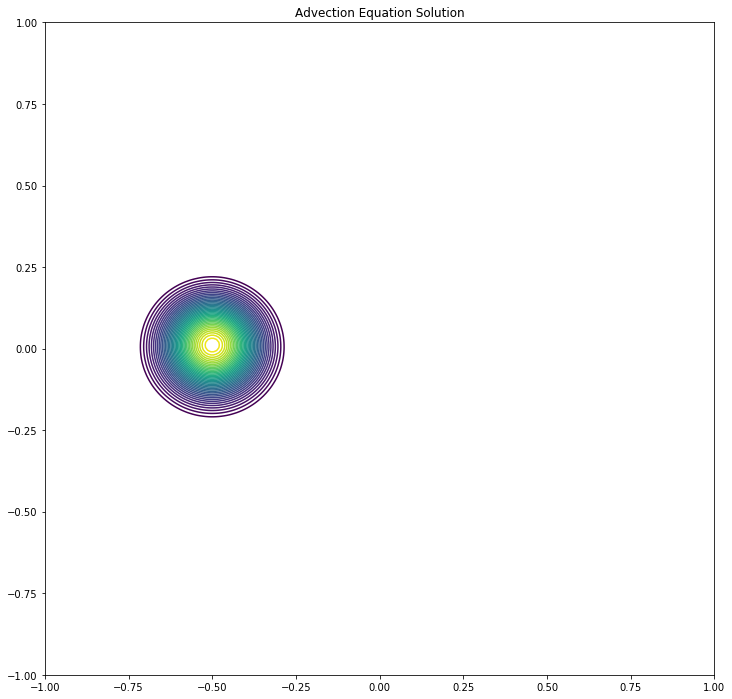

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -1.168811791430277465e-06 0.99889587428002100993
float128


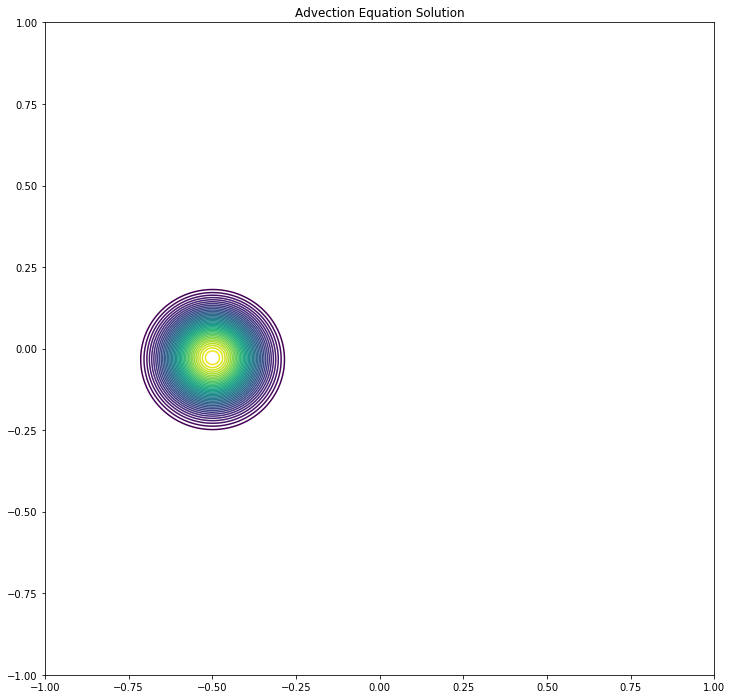

Budget error:  0.0 
qmin, qmax:  -1.3540220657457858721e-06 0.9993464572339836268
float128


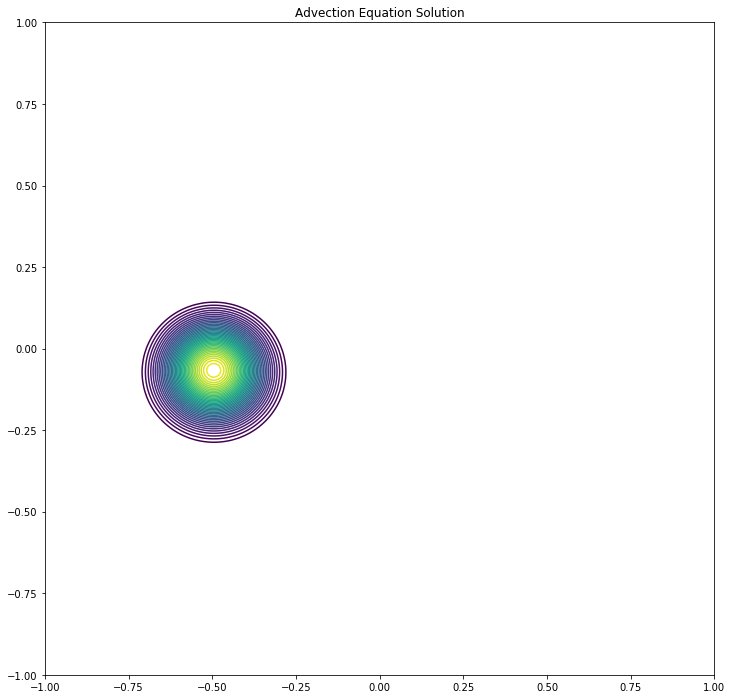

Budget error:  0.0 
qmin, qmax:  -1.3615155668357918514e-06 0.99930356195427508915
float128


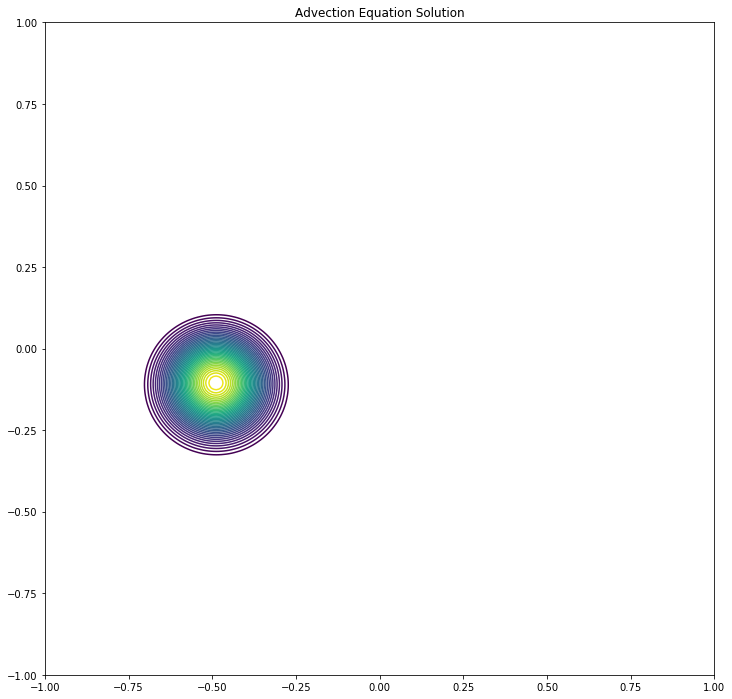

Budget error:  0.0 
qmin, qmax:  -1.3567263511220318075e-06 0.9990479295751776778
float128


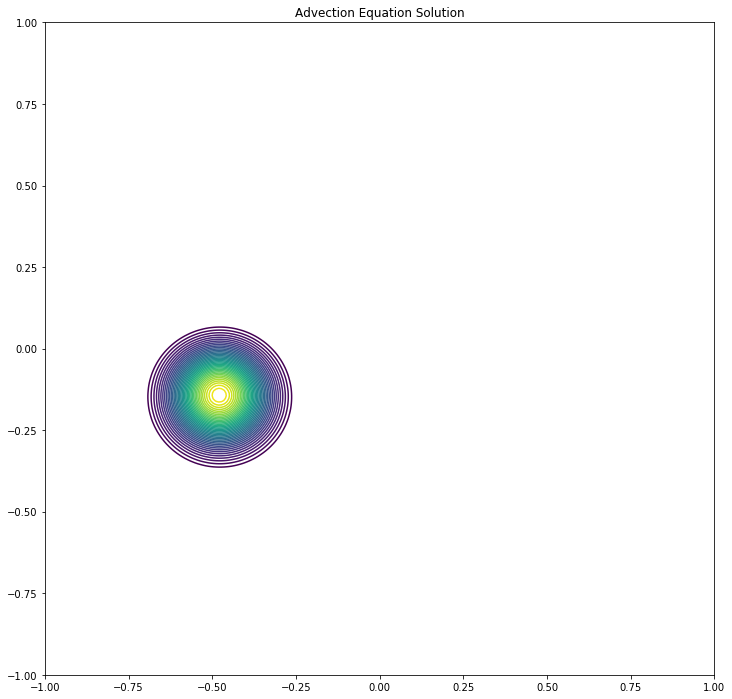

Budget error:  0.0 
qmin, qmax:  -1.3538217679873132912e-06 0.99841215332911905376
float128


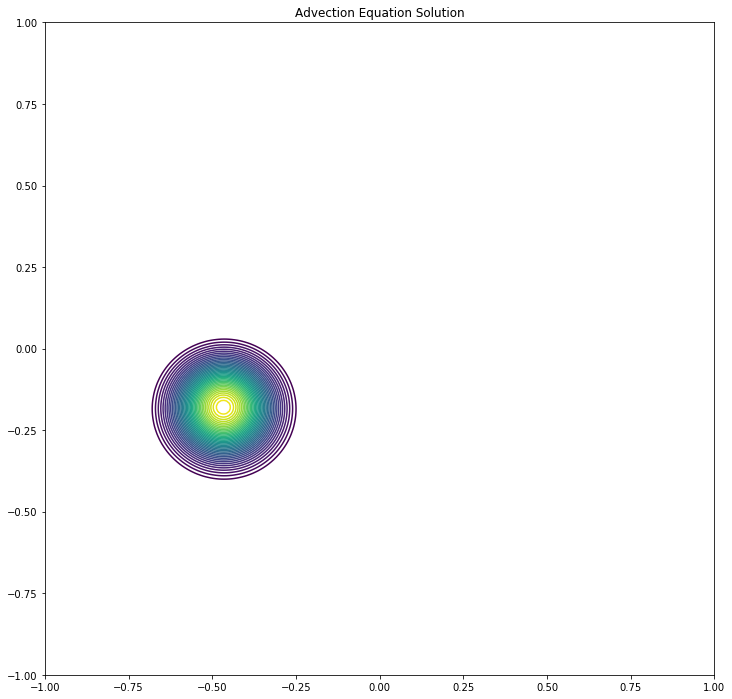

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -1.3888165401709320805e-06 0.99901908296553206375
float128


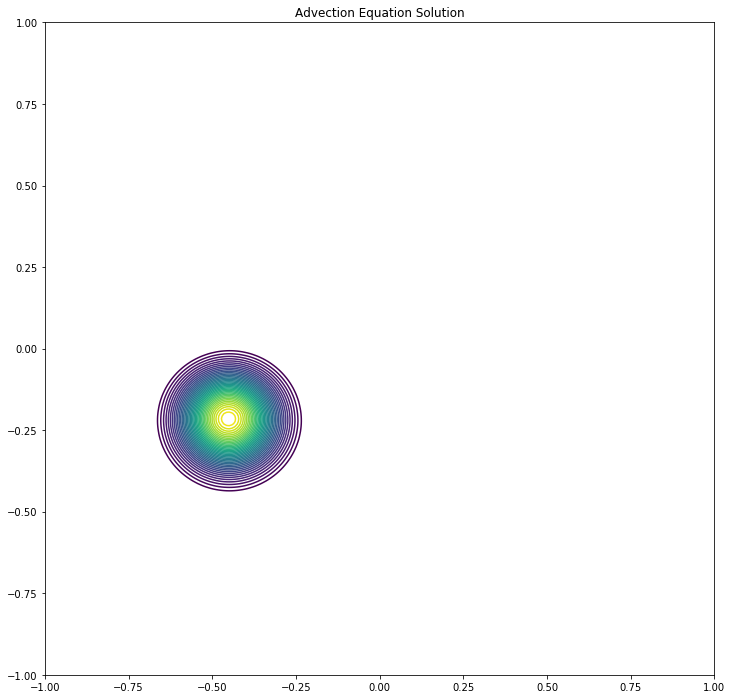

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -1.731404303473279508e-06 0.99853084702185872034
float128


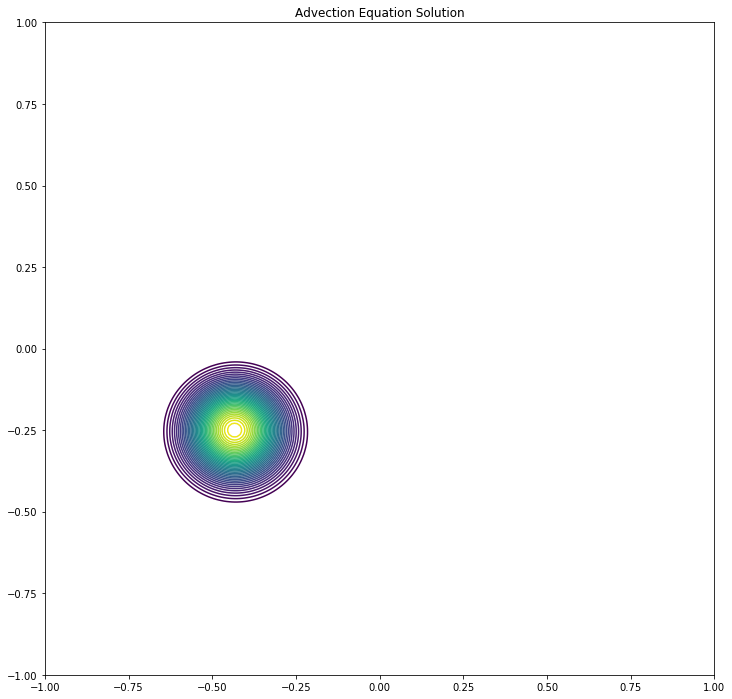

Budget error:  0.0 
qmin, qmax:  -1.5715928830880120037e-06 0.99861724149232521374
float128


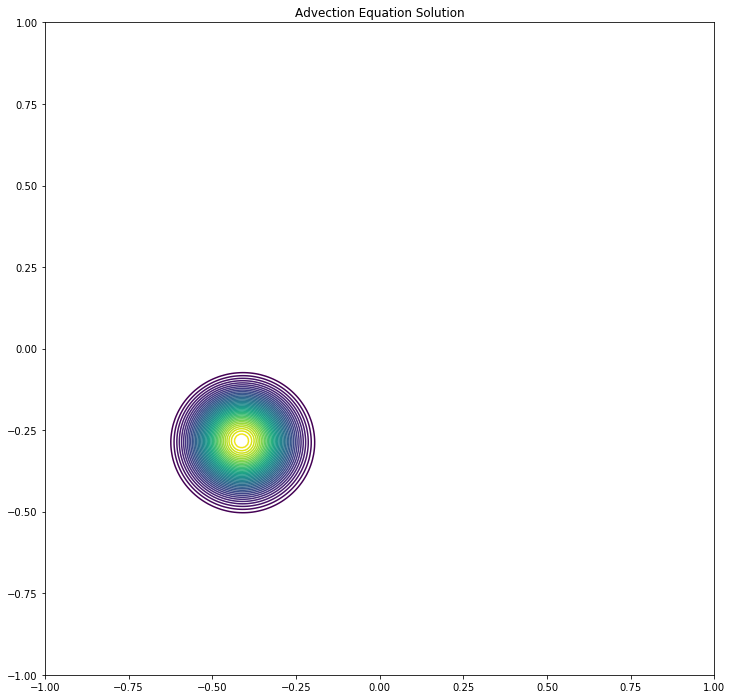

Budget error:  -1.3552527156068805425e-20 
qmin, qmax:  -1.5177222822261833356e-06 0.9985339016031144637
float128


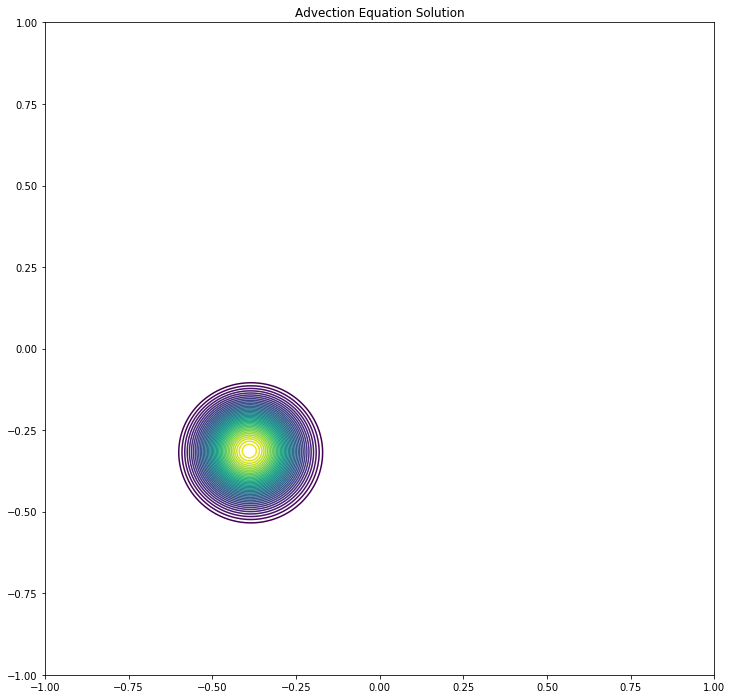

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -1.2703081023893448896e-06 0.9985196091021133378
float128


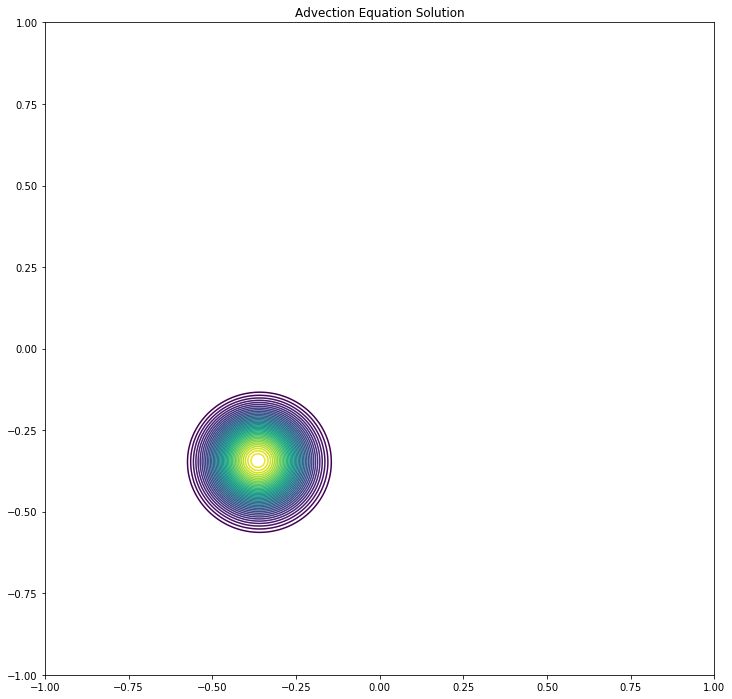

Budget error:  0.0 
qmin, qmax:  -1.0493881280350543624e-06 0.99836485351963151323
float128


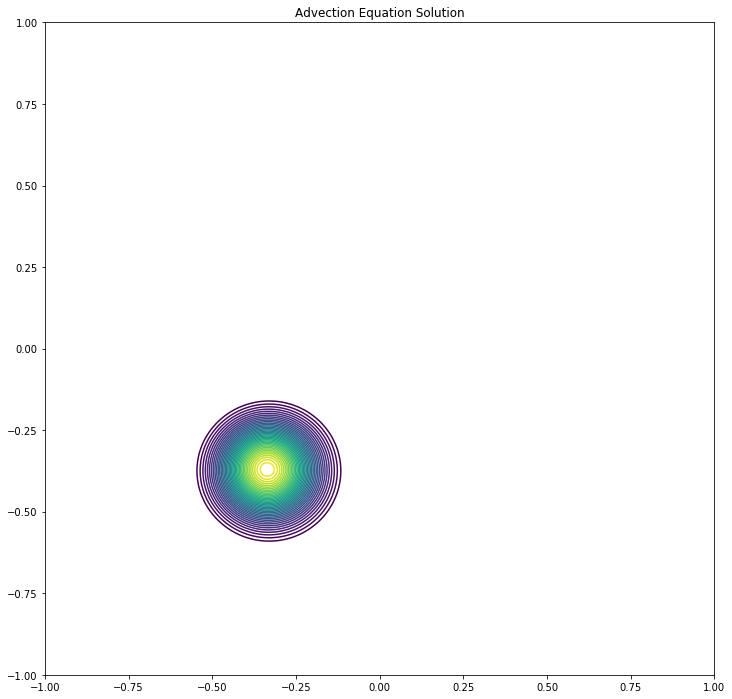

Budget error:  0.0 
qmin, qmax:  -1.041743767949975508e-06 0.99861801017065823446
float128


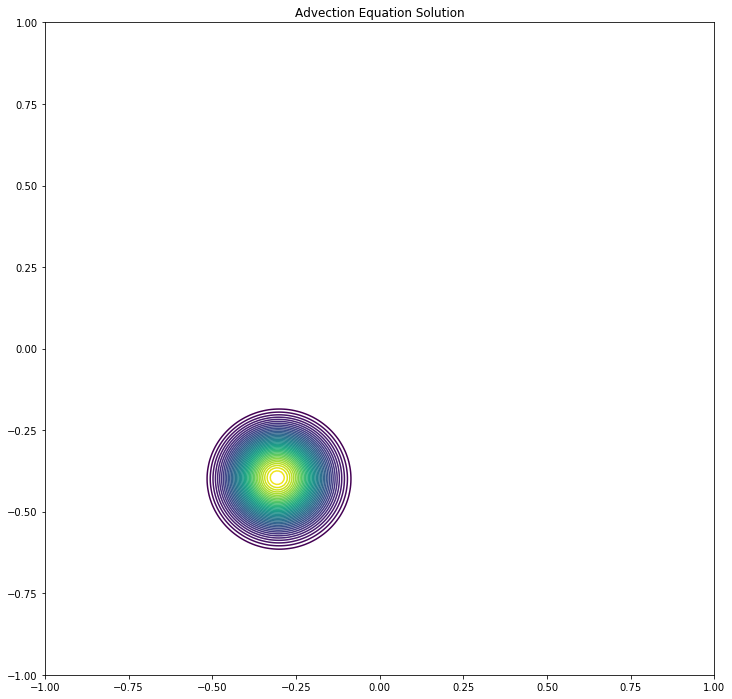

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -1.0300284063201540676e-06 0.9984948196336713483
float128


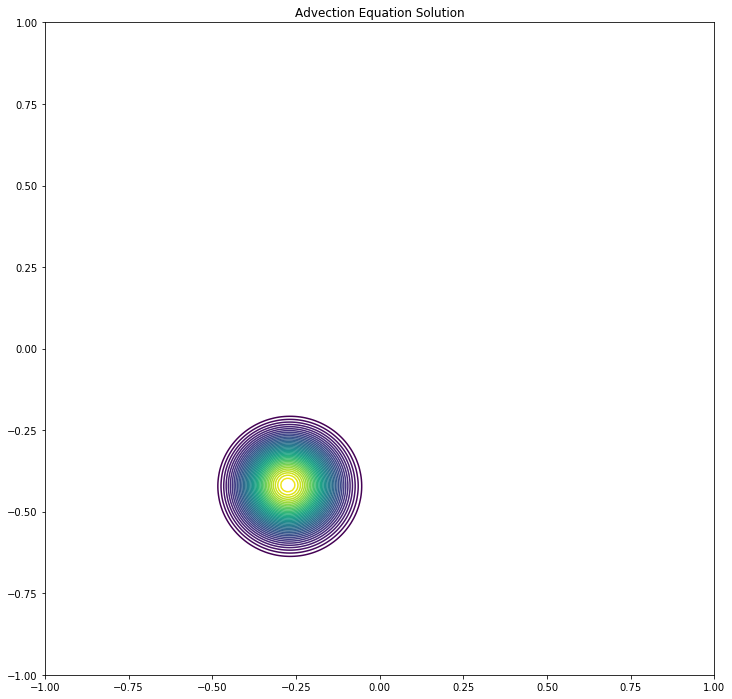

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -1.0060701669097456818e-06 0.9981116059089205964
float128


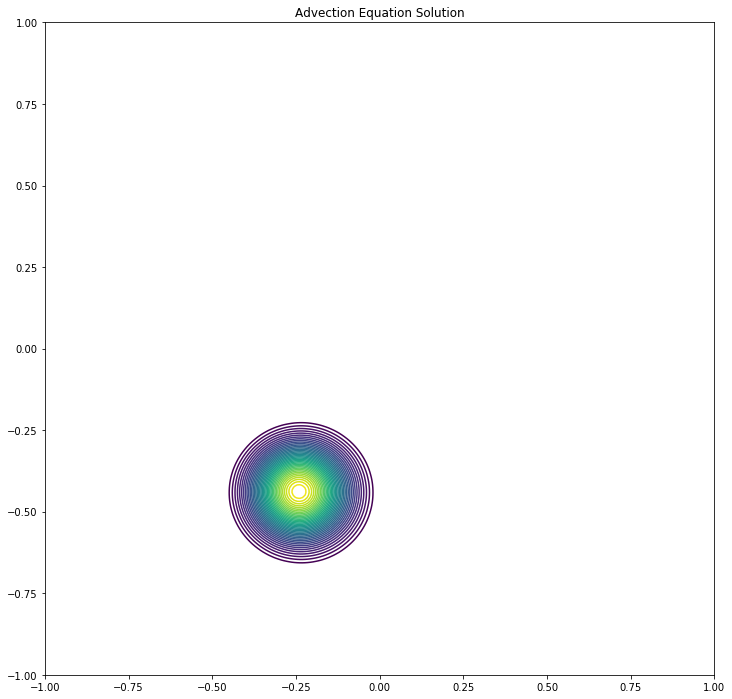

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -9.792746887487233091e-07 0.9987578898671625389
float128


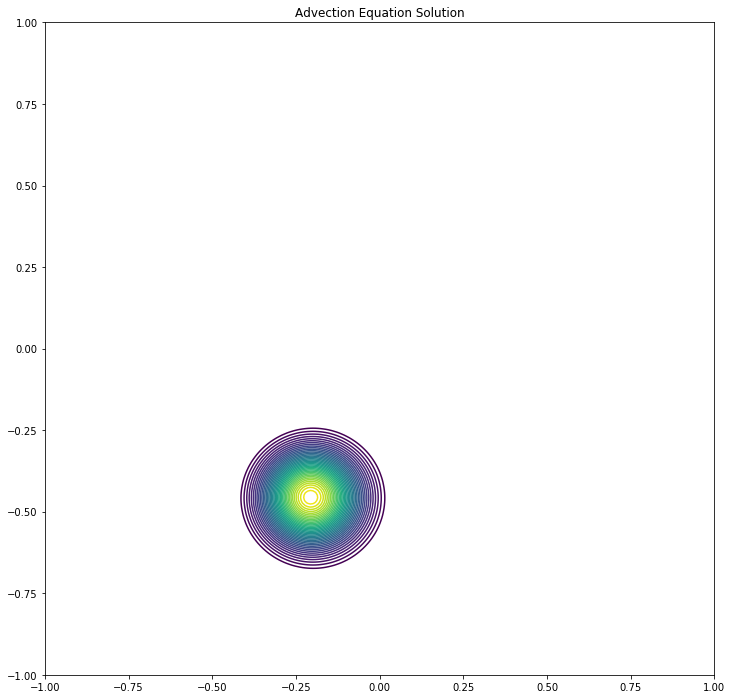

Budget error:  0.0 
qmin, qmax:  -9.749420421662677341e-07 0.9983939220638784931
float128


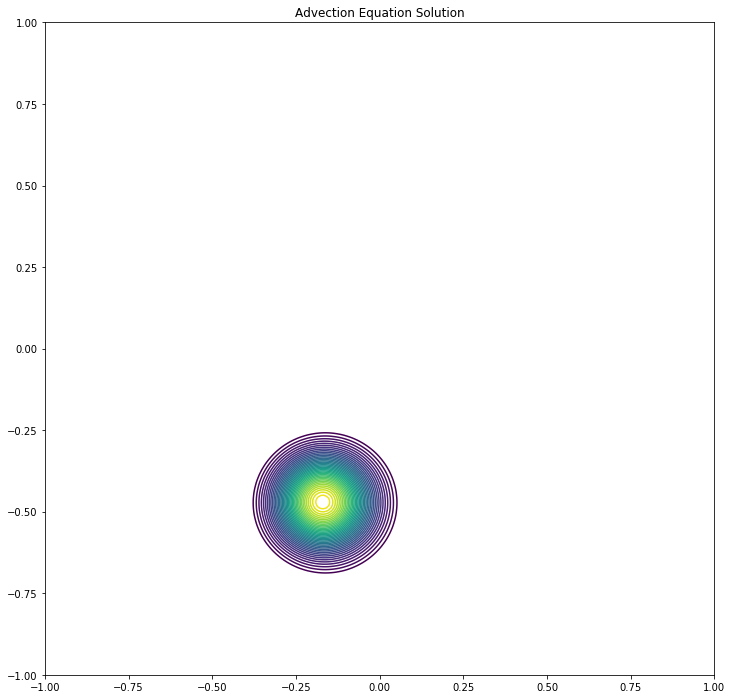

Budget error:  0.0 
qmin, qmax:  -1.0691839194009069827e-06 0.99796756875276647044
float128


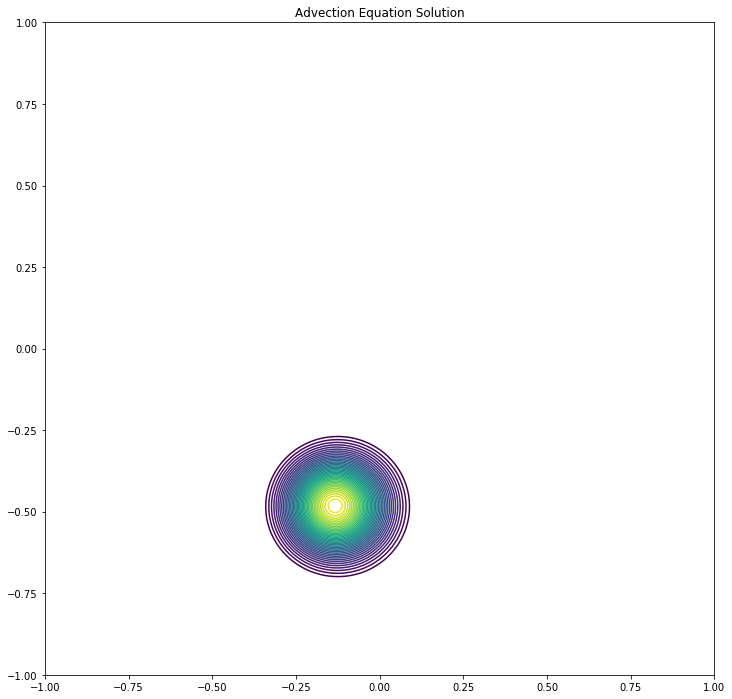

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -1.2347598534115631256e-06 0.9980899673358044865
float128


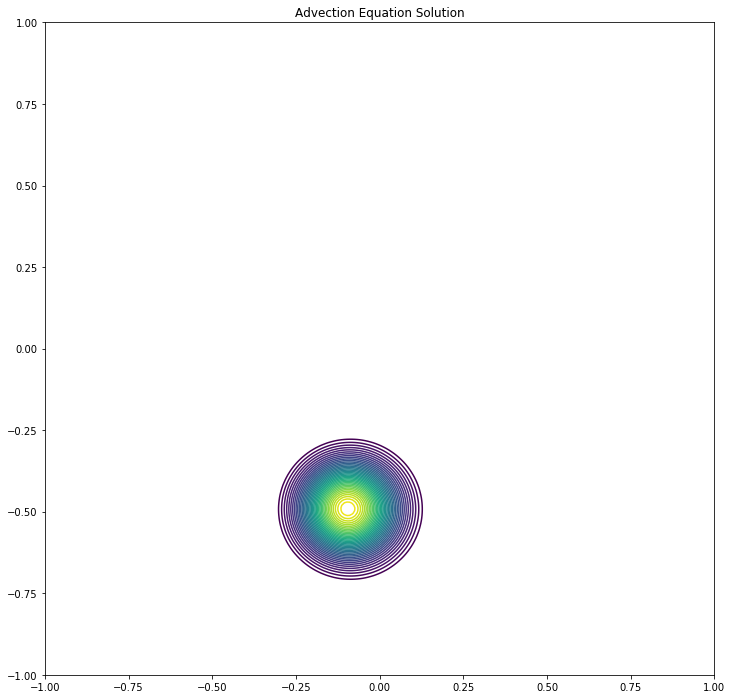

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -1.2254256585077356597e-06 0.9985051128638213643
float128


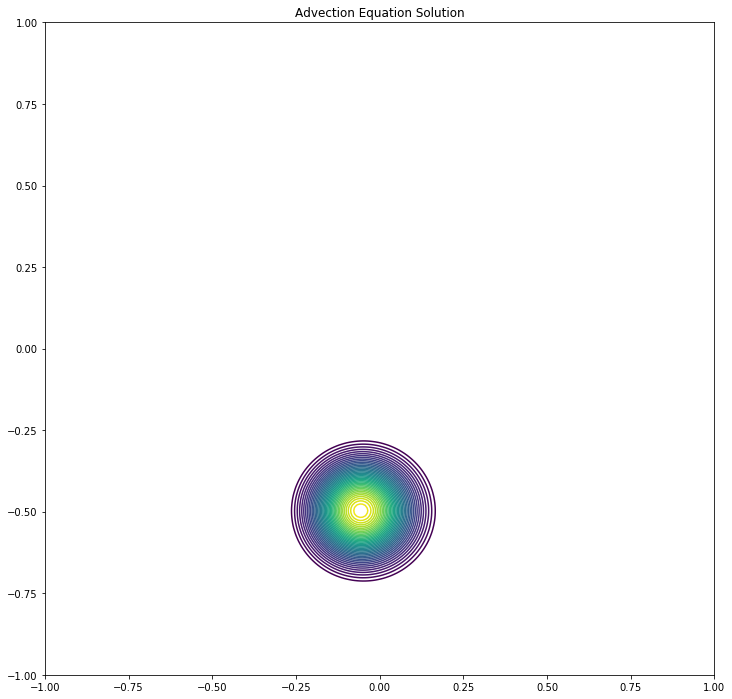

Budget error:  0.0 
qmin, qmax:  -1.0558307629056606328e-06 0.99789990370025471344
float128


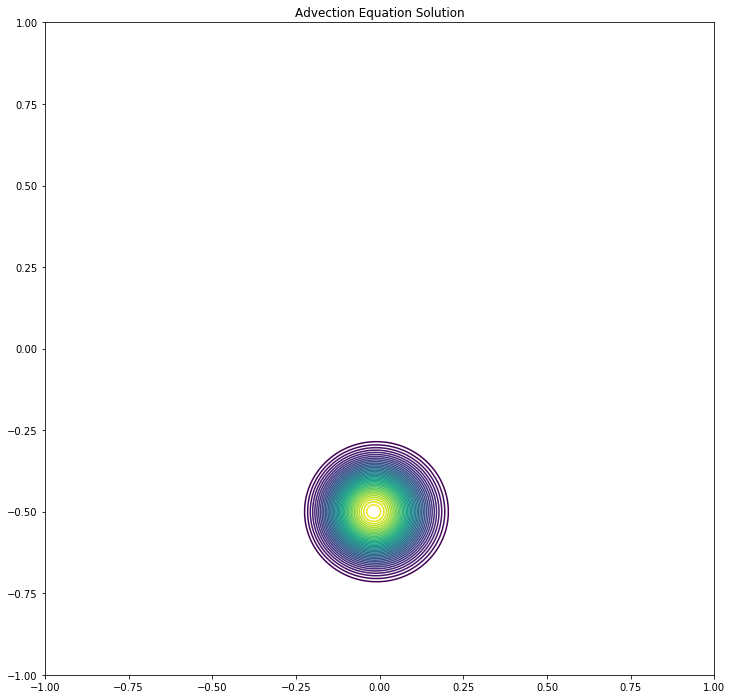

Budget error:  0.0 
qmin, qmax:  -1.0284480546864394316e-06 0.99793297585792978006
float128


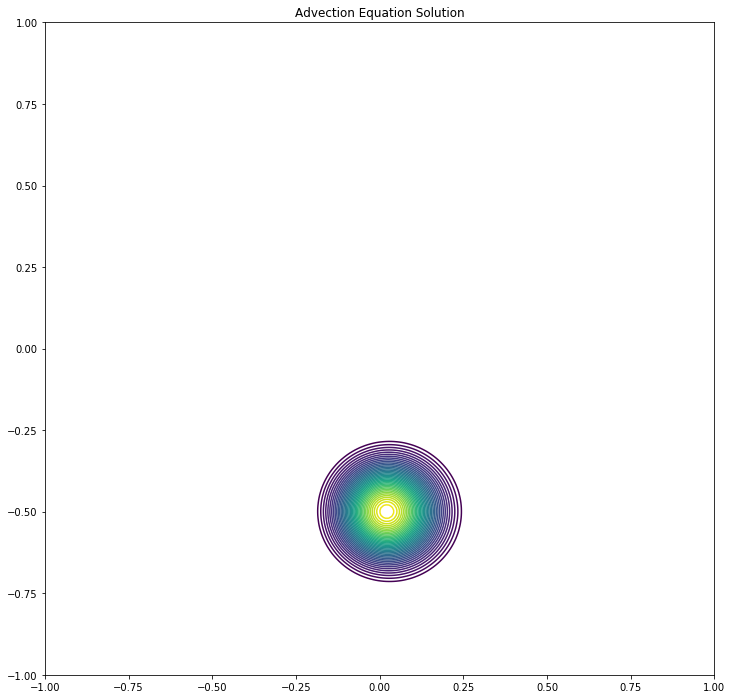

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -1.0796910470561112946e-06 0.99851515525551039687
float128


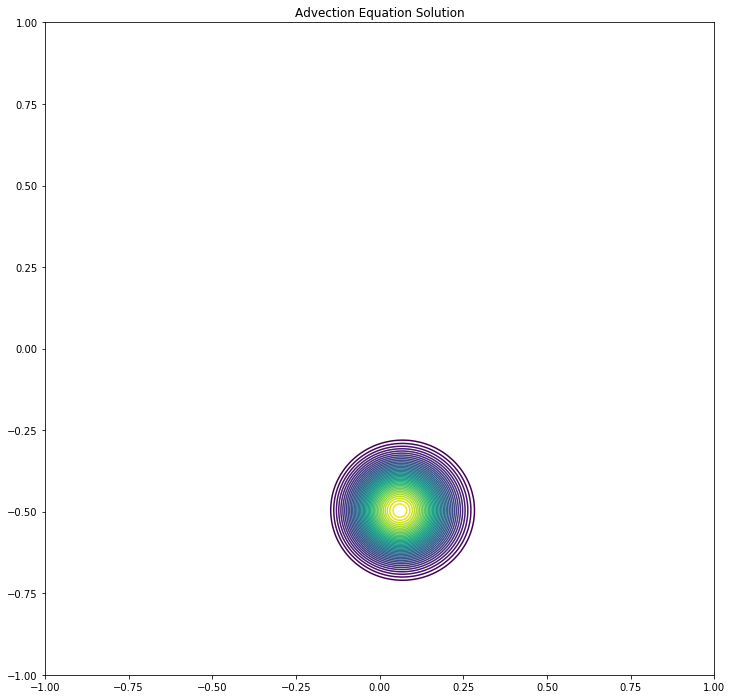

Budget error:  0.0 
qmin, qmax:  -1.0394636179910368361e-06 0.9983751676940133149
float128


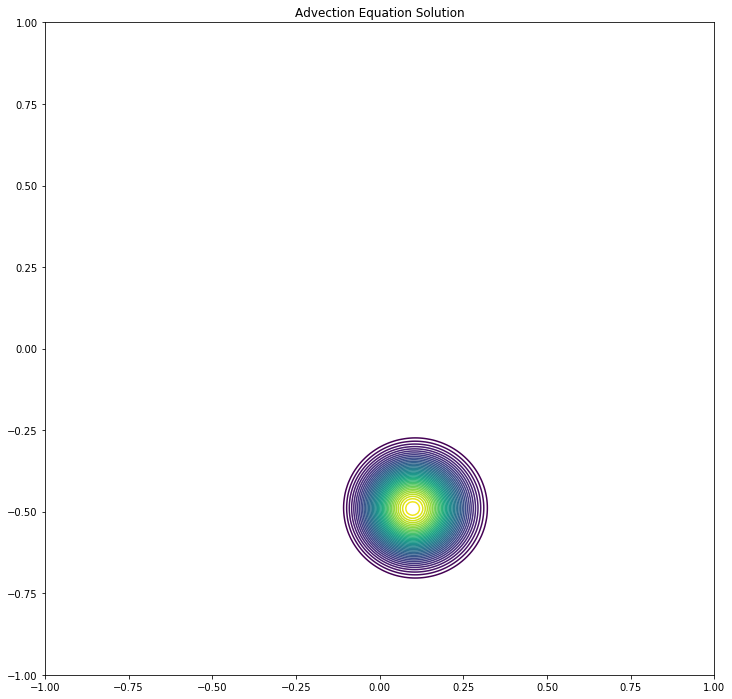

Budget error:  0.0 
qmin, qmax:  -1.0669085614999119888e-06 0.99852992560736334495
float128


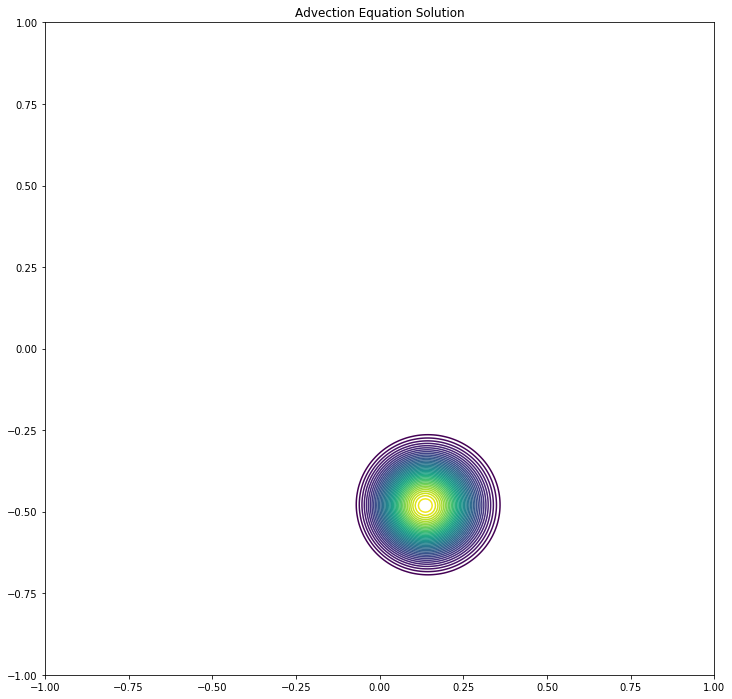

Budget error:  -2.0328790734103208138e-20 
qmin, qmax:  -1.0810492300259135556e-06 0.9975356730819453866
float128


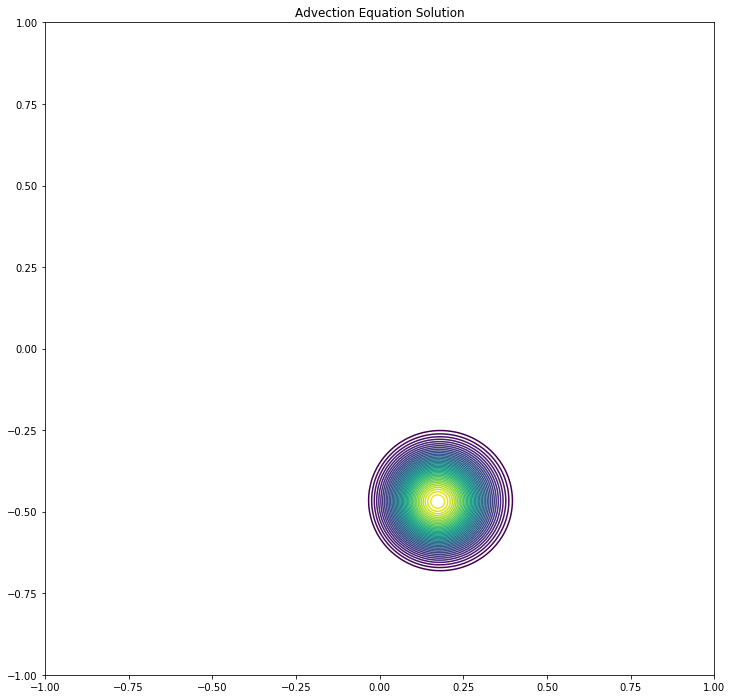

Budget error:  0.0 
qmin, qmax:  -1.4704123014033247062e-06 0.99772699331349410013
float128


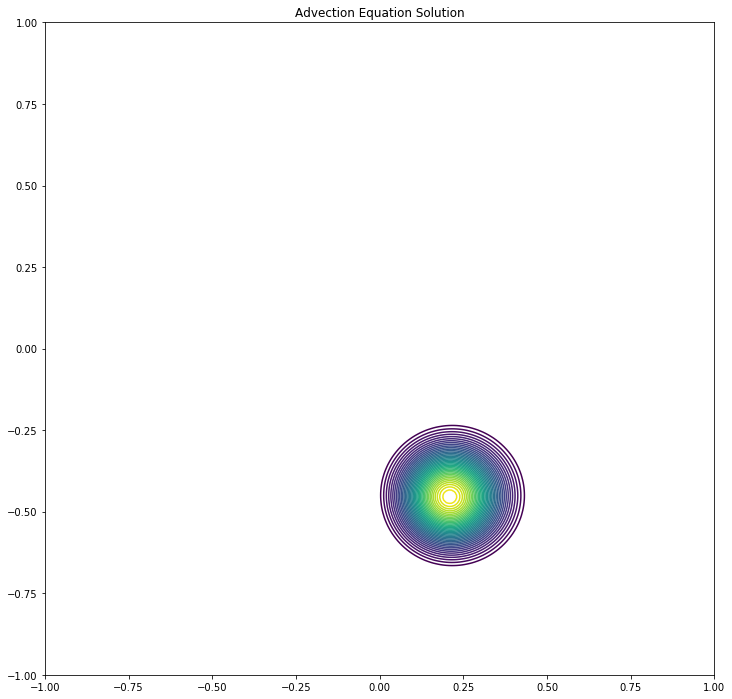

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -1.5033241074974672994e-06 0.99783788505247424496
float128


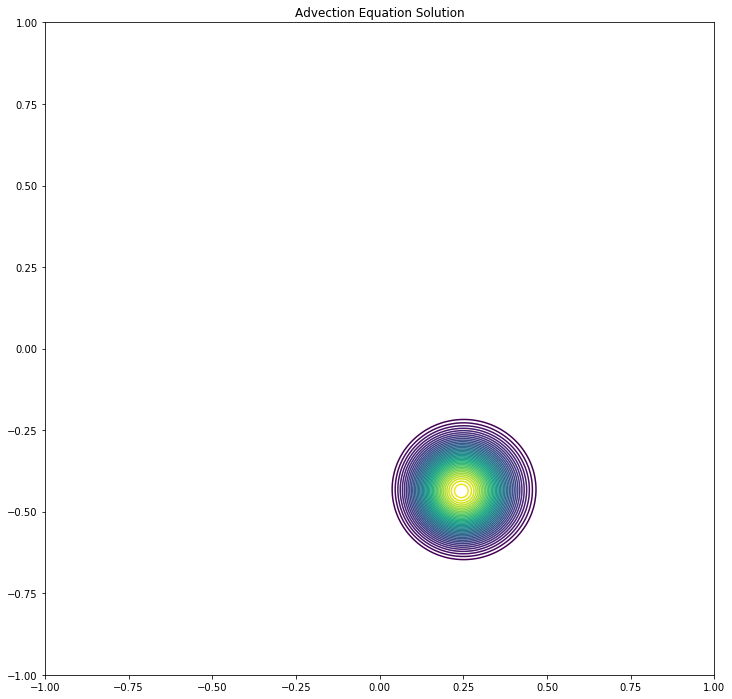

Budget error:  -1.3552527156068805425e-20 
qmin, qmax:  -1.5329563743443487617e-06 0.9981750174699612963
float128


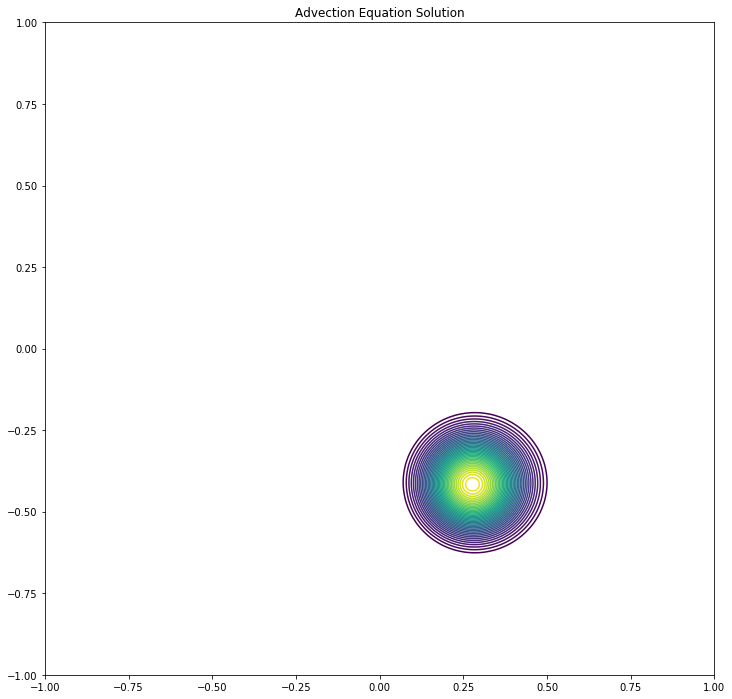

Budget error:  -1.3552527156068805425e-20 
qmin, qmax:  -1.1623267106130402047e-06 0.99822285505552678527
float128


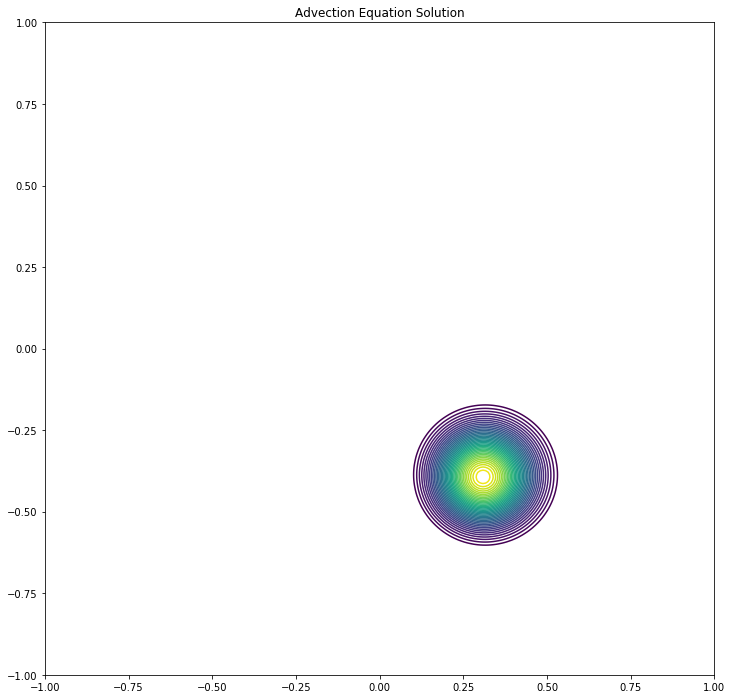

Budget error:  -1.3552527156068805425e-20 
qmin, qmax:  -1.1777750644212085266e-06 0.9976865859559316502
float128


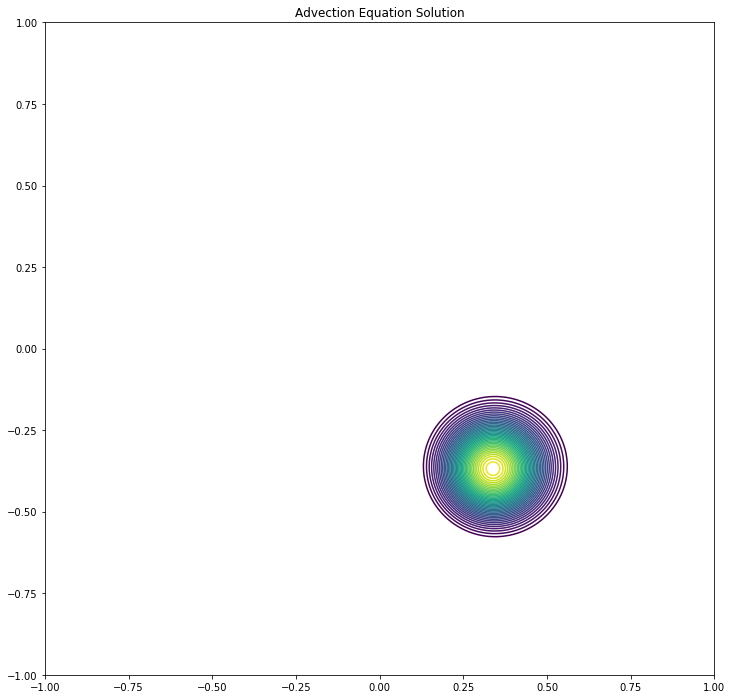

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -1.1603240182181212638e-06 0.99780431554791189217
float128


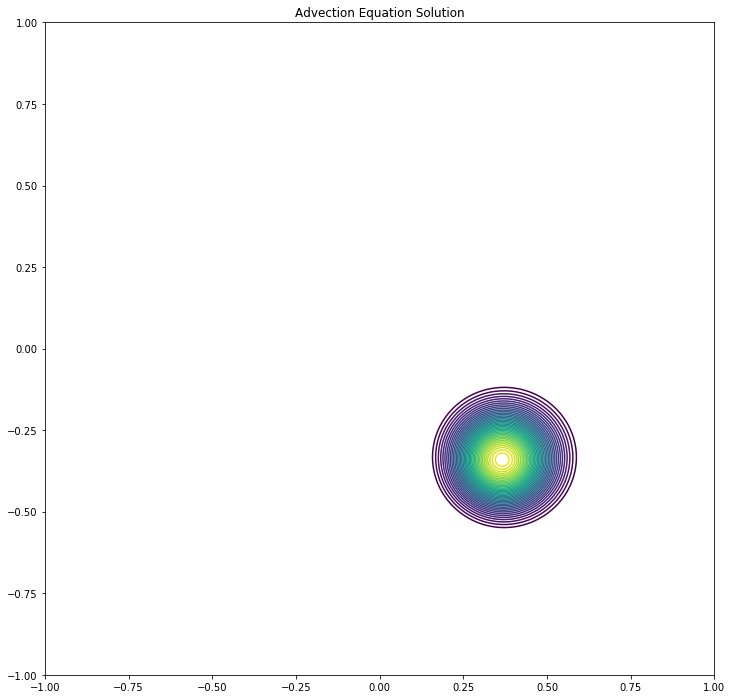

Budget error:  0.0 
qmin, qmax:  -1.1694992251434708833e-06 0.9974254454556367685
float128


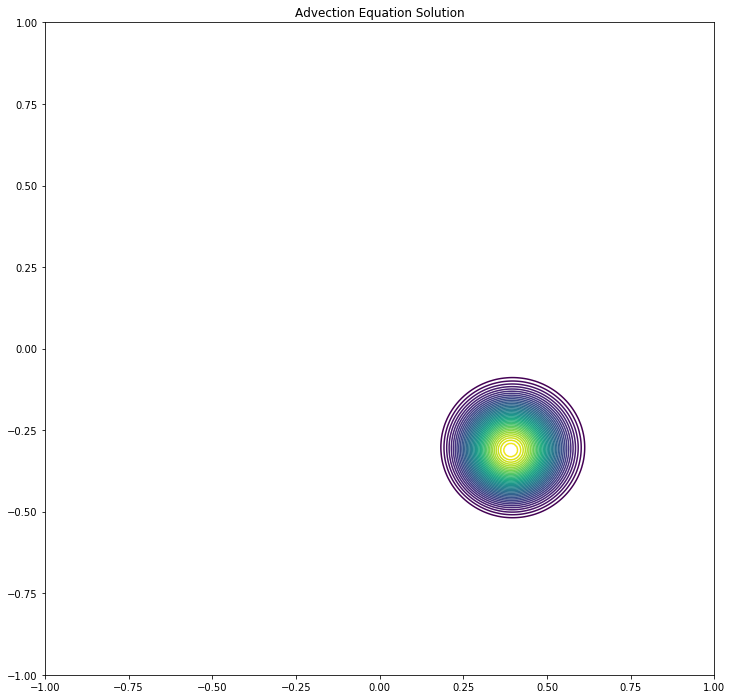

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -1.1548700588887893306e-06 0.99727325907164135975
float128


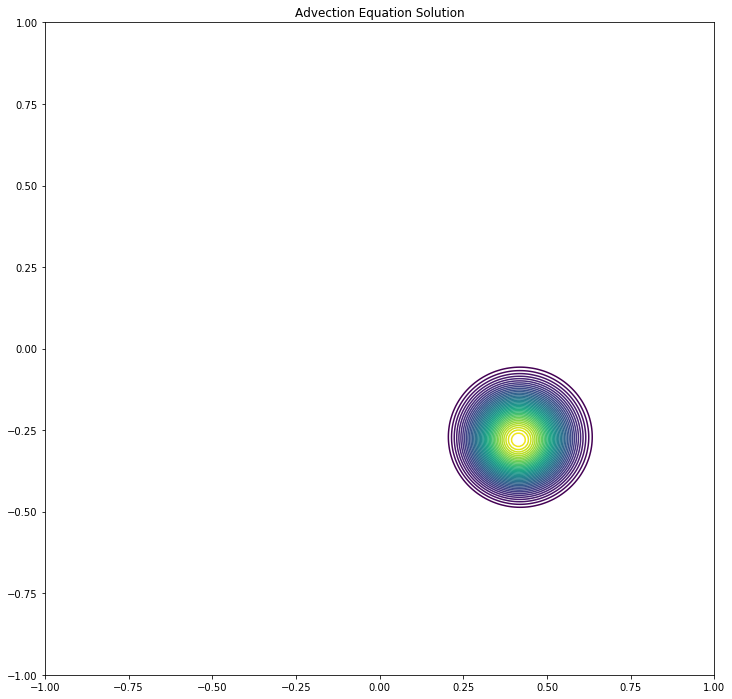

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -1.1453979482881080013e-06 0.99796622227440496736
float128


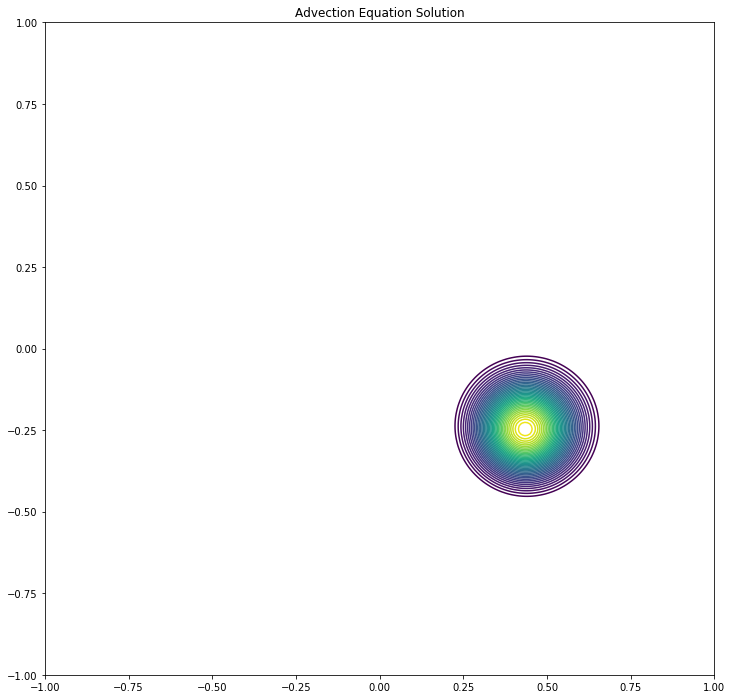

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -1.2891744644869929668e-06 0.99693513159551378383
float128


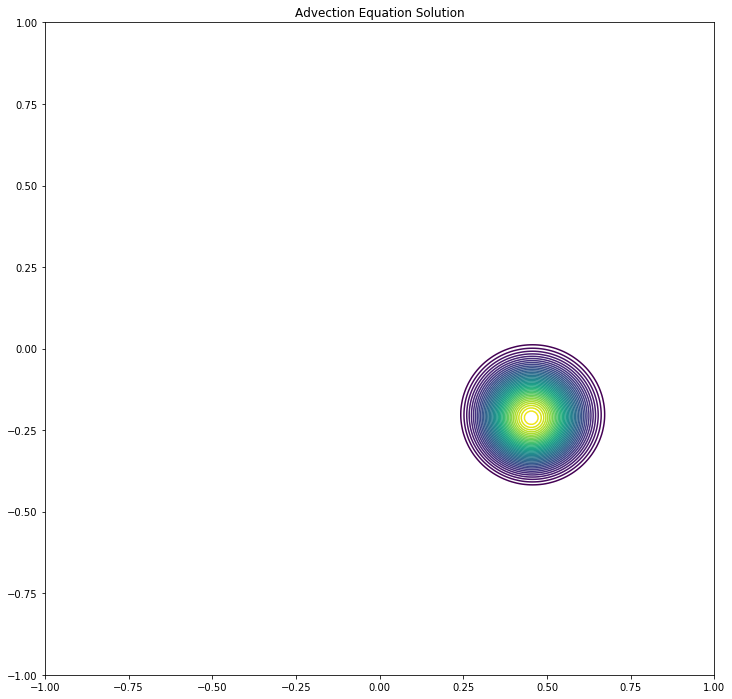

Budget error:  0.0 
qmin, qmax:  -1.130445759960620613e-06 0.99748398236816480234
float128


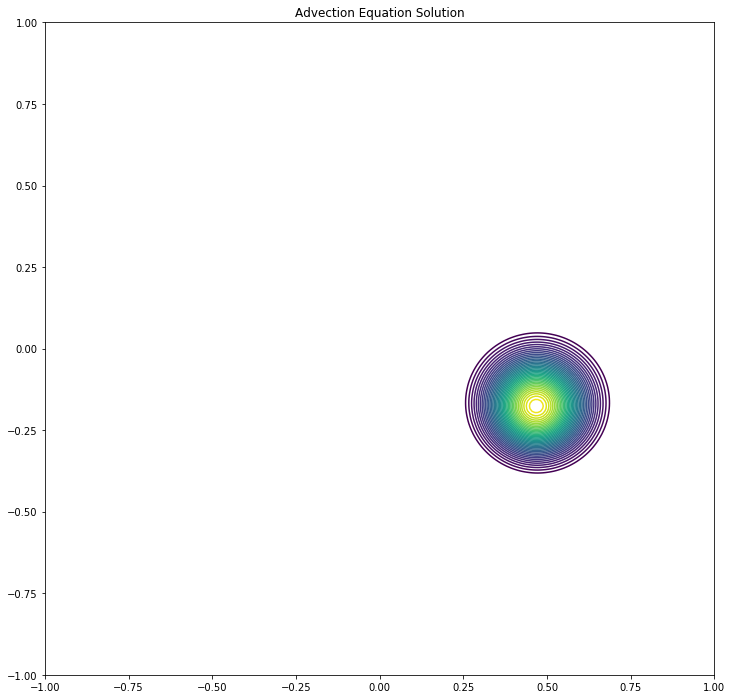

Budget error:  -1.3552527156068805425e-20 
qmin, qmax:  -1.2045993630072503391e-06 0.9976439800748537149
float128


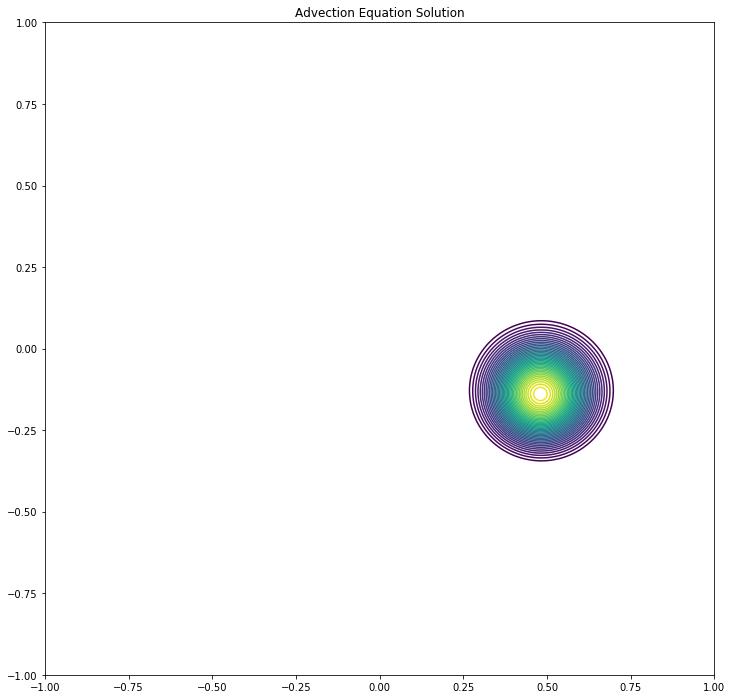

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -1.4166237077392542026e-06 0.99713528878882051694
float128


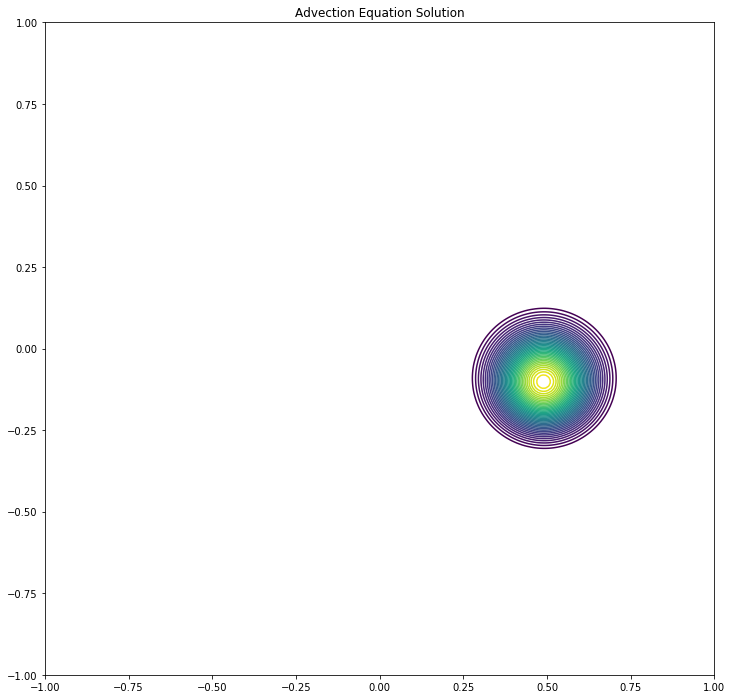

Budget error:  0.0 
qmin, qmax:  -1.4447309001072582942e-06 0.99719099140662852723
float128


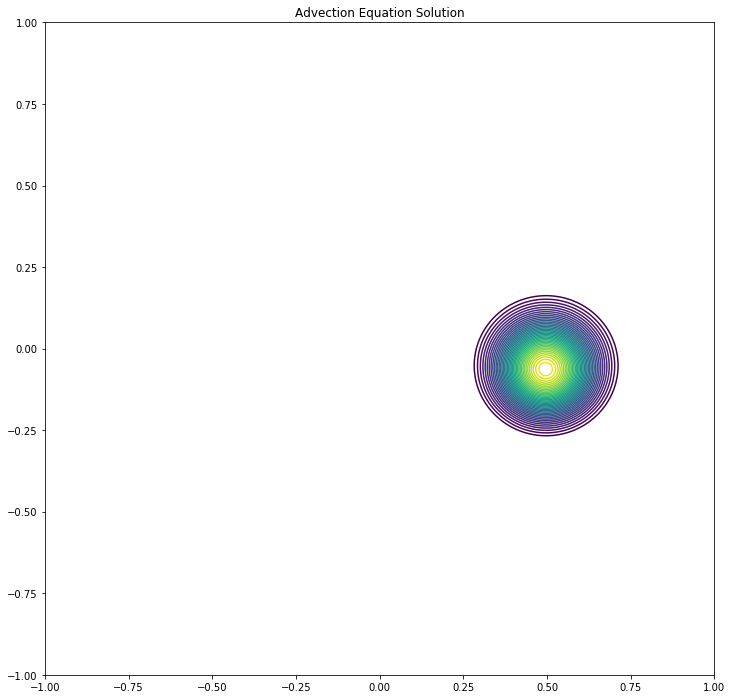

Budget error:  0.0 
qmin, qmax:  -1.3107955006953065931e-06 0.9966956720171920596
float128


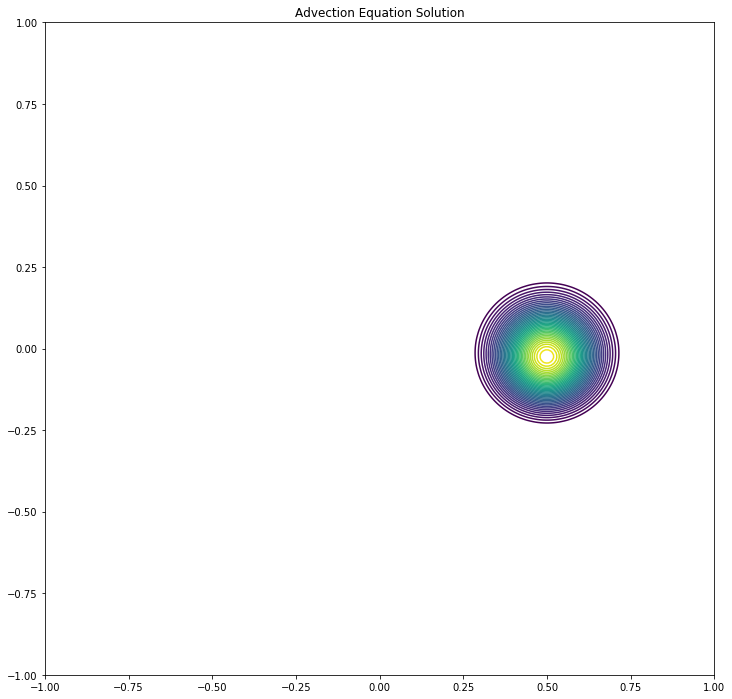

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -1.2501359558276867357e-06 0.99655899775181893834
float128


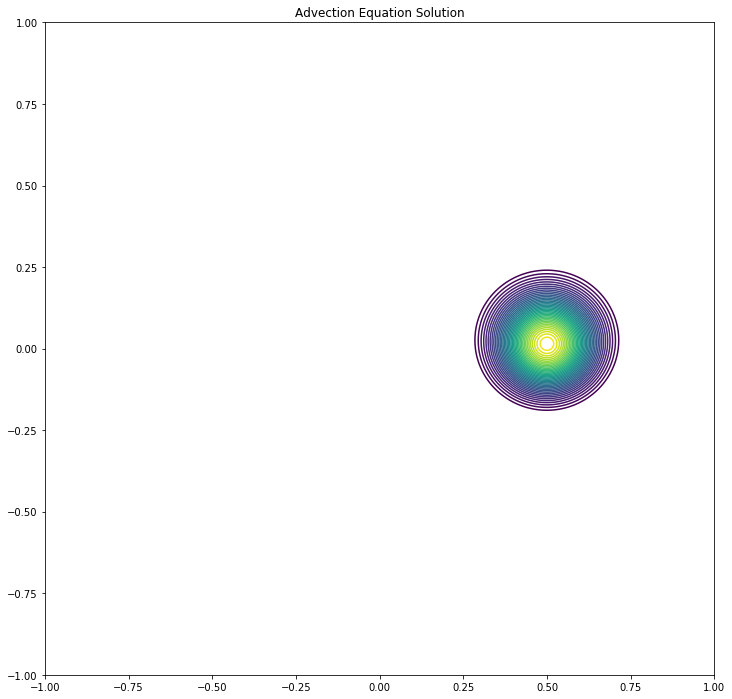

Budget error:  0.0 
qmin, qmax:  -1.1686132408152137515e-06 0.9971832664630511162
float128


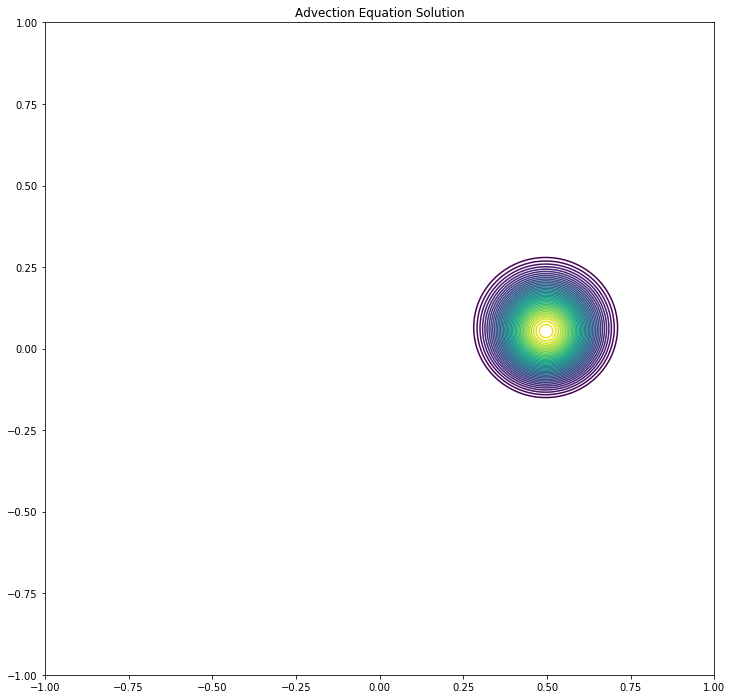

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -1.053129105213848681e-06 0.99683962892609320137
float128


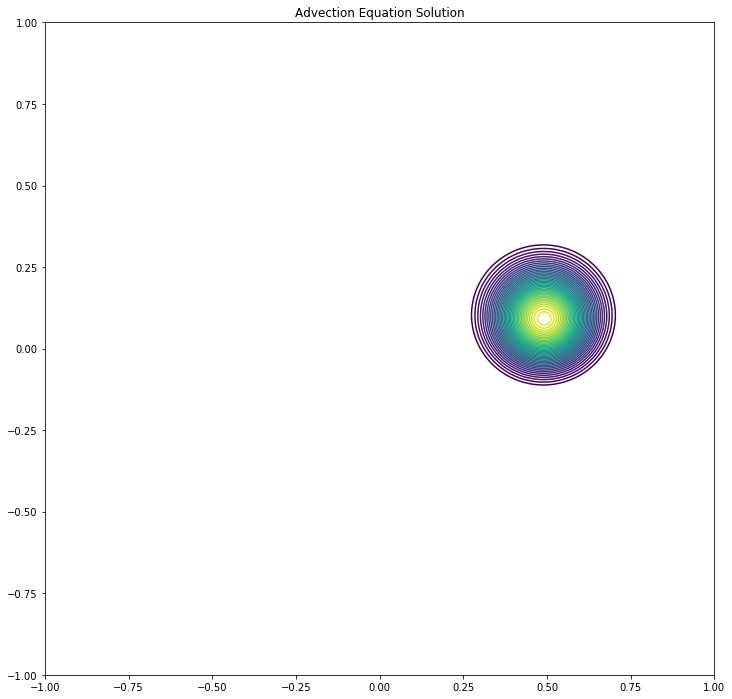

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -1.3650869733054790137e-06 0.99720851844586681675
float128


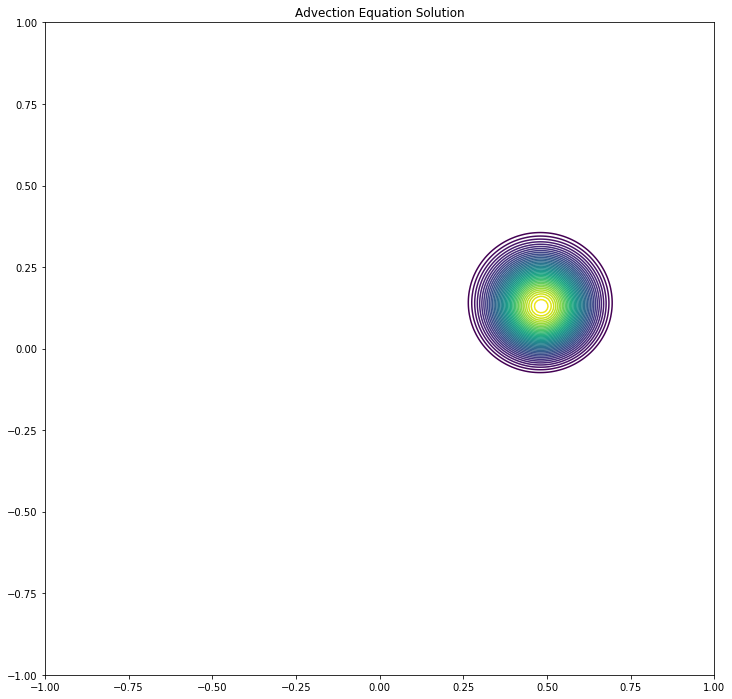

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -1.6954372867604133371e-06 0.99734201900172451223
float128


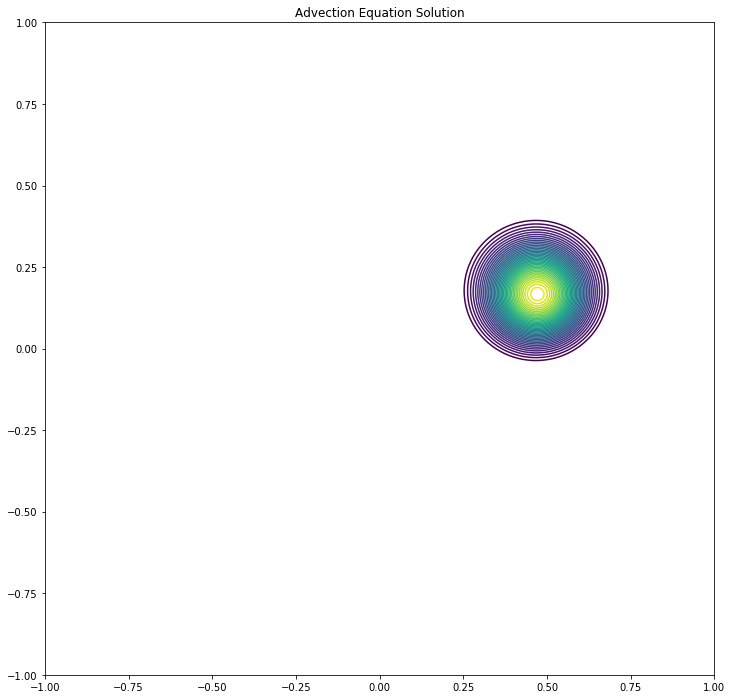

Budget error:  0.0 
qmin, qmax:  -2.0773315775749950615e-06 0.99679714626292024196
float128


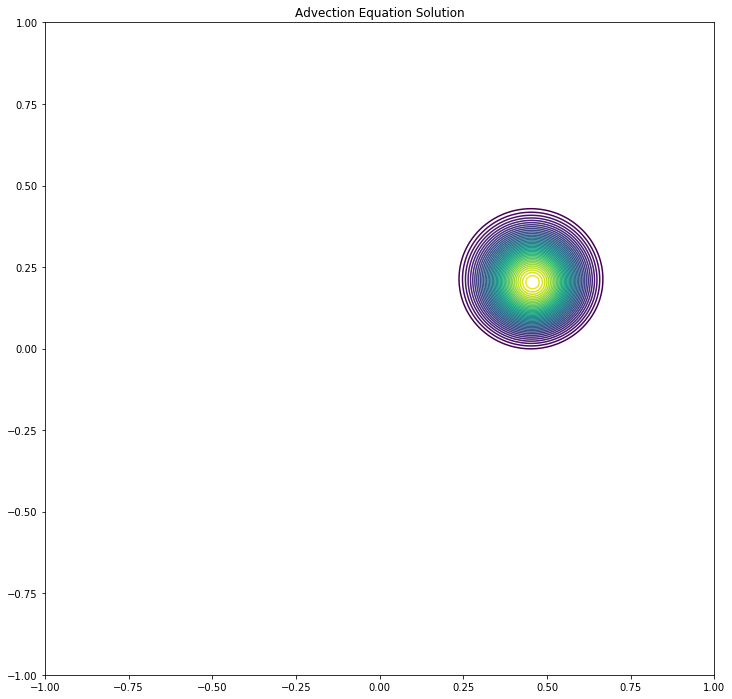

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -2.447438690659592712e-06 0.9971710038155959783
float128


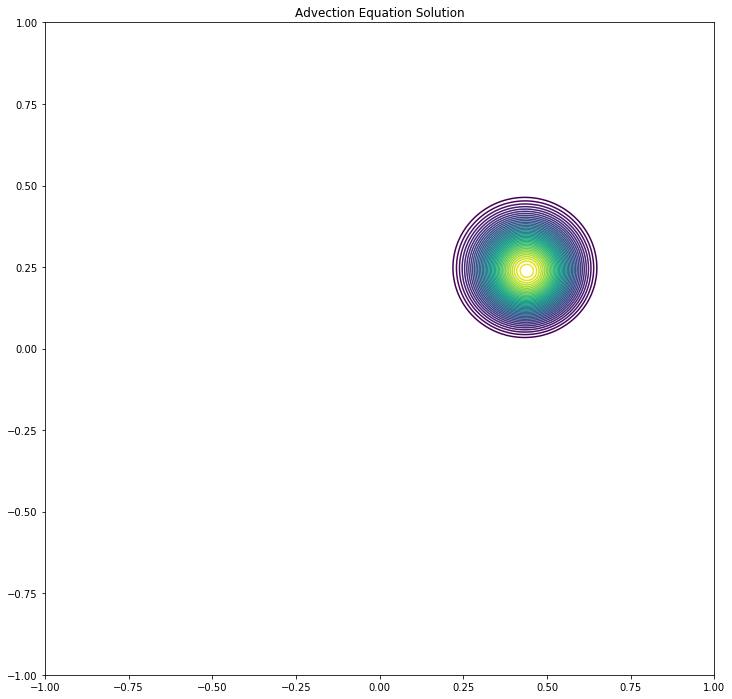

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -2.8509386731143904533e-06 0.9969033210451497429
float128


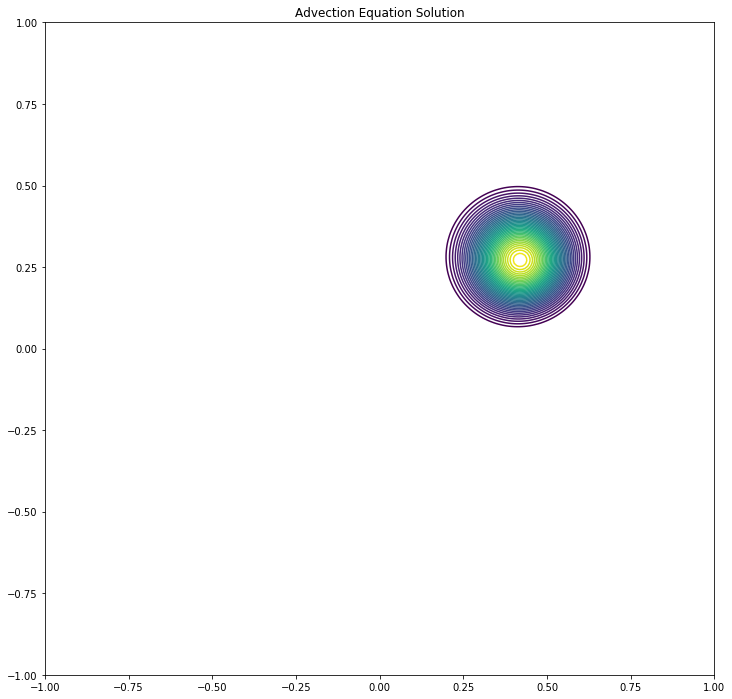

Budget error:  0.0 
qmin, qmax:  -3.203166047333393264e-06 0.99648241951051580076
float128


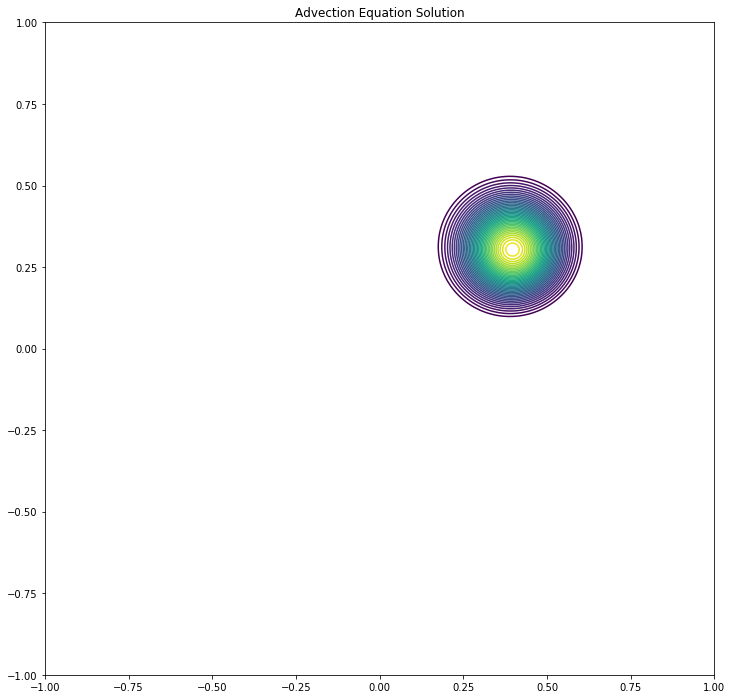

Budget error:  0.0 
qmin, qmax:  -3.622244577293688312e-06 0.99697440838467326116
float128


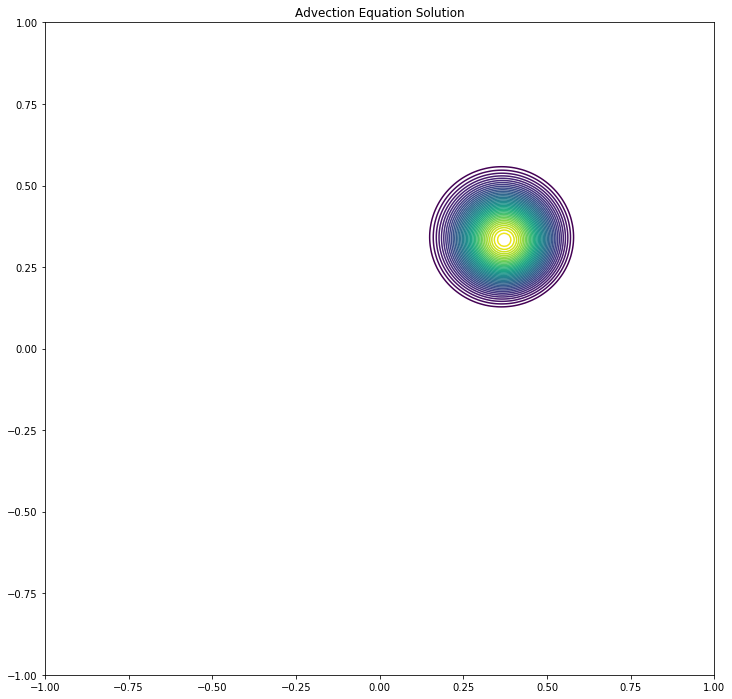

Budget error:  -1.3552527156068805425e-20 
qmin, qmax:  -3.9908107152584961044e-06 0.9966866228973417221
float128


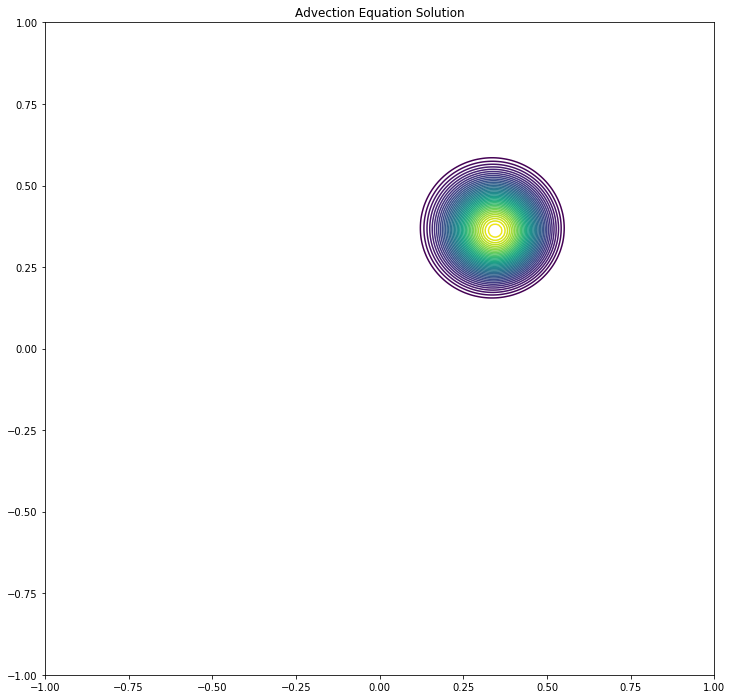

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -4.3618985543508498836e-06 0.99702769755982591893
float128


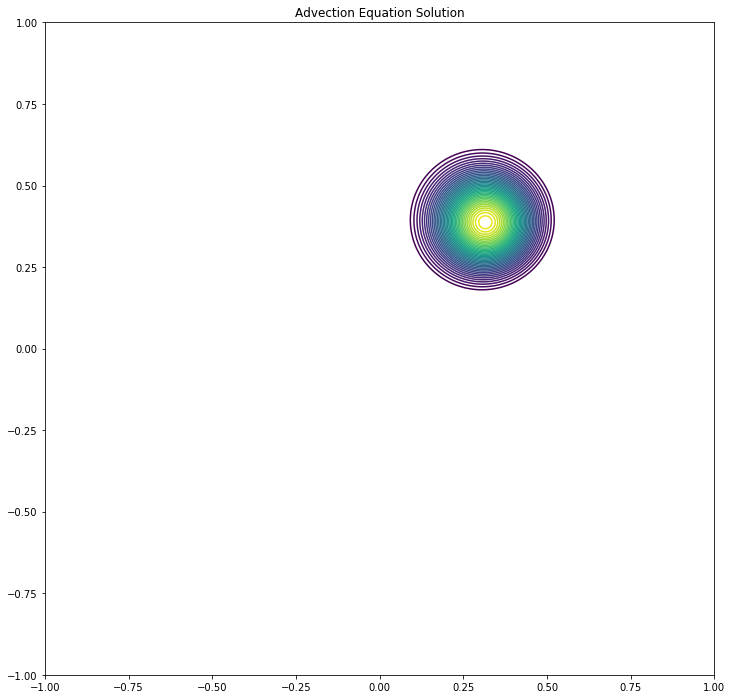

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -4.746189730391024056e-06 0.99697166454964715156
float128


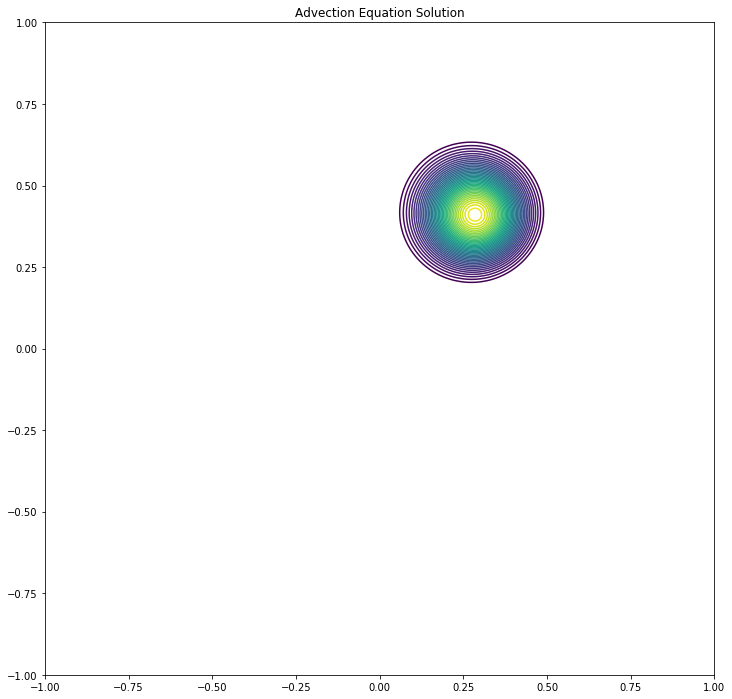

Budget error:  0.0 
qmin, qmax:  -5.2246319543437369136e-06 0.9965969223448225163
float128


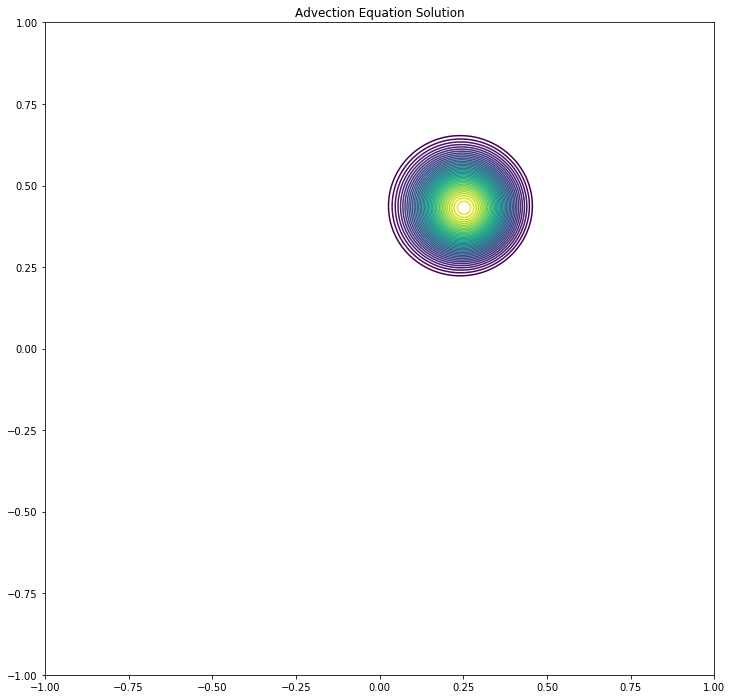

Budget error:  0.0 
qmin, qmax:  -5.777936067326267683e-06 0.9964316385490112323
float128


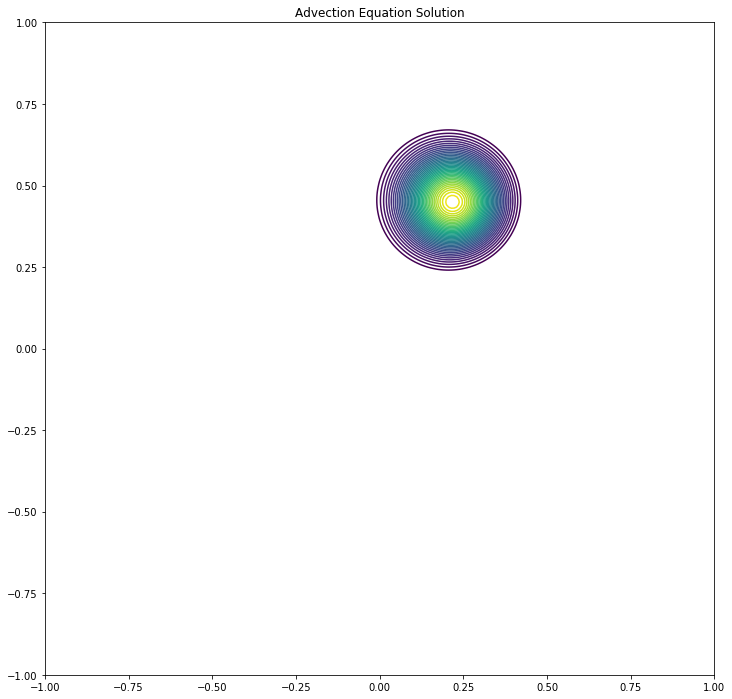

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -6.4841022307676380143e-06 0.99665827019586108554
float128


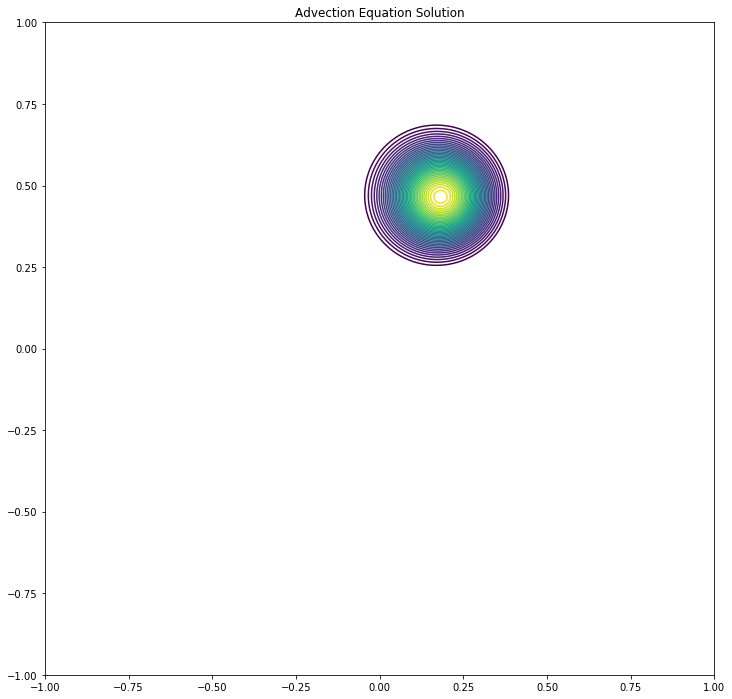

Budget error:  0.0 
qmin, qmax:  -7.4269467653994488974e-06 0.99650264094528985255
float128


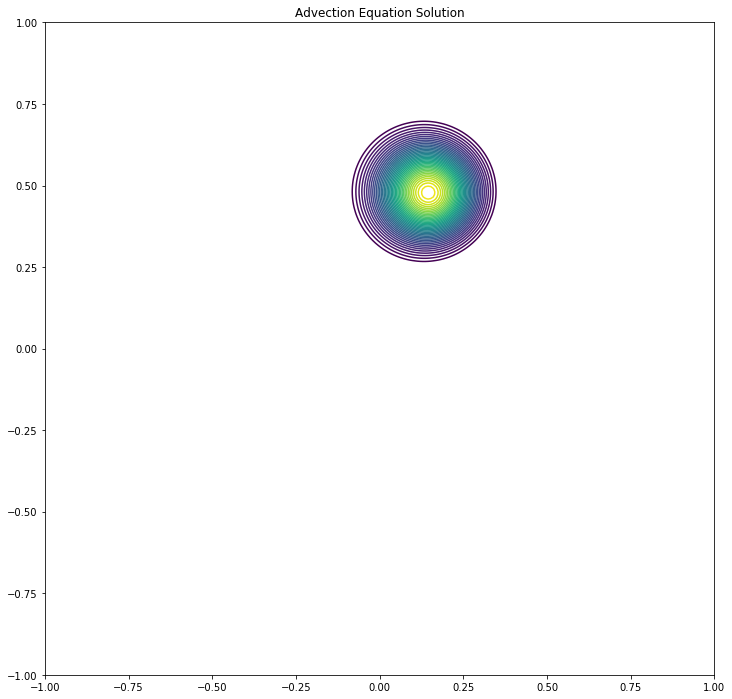

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -8.65675886914615015e-06 0.9964625044685672477
float128


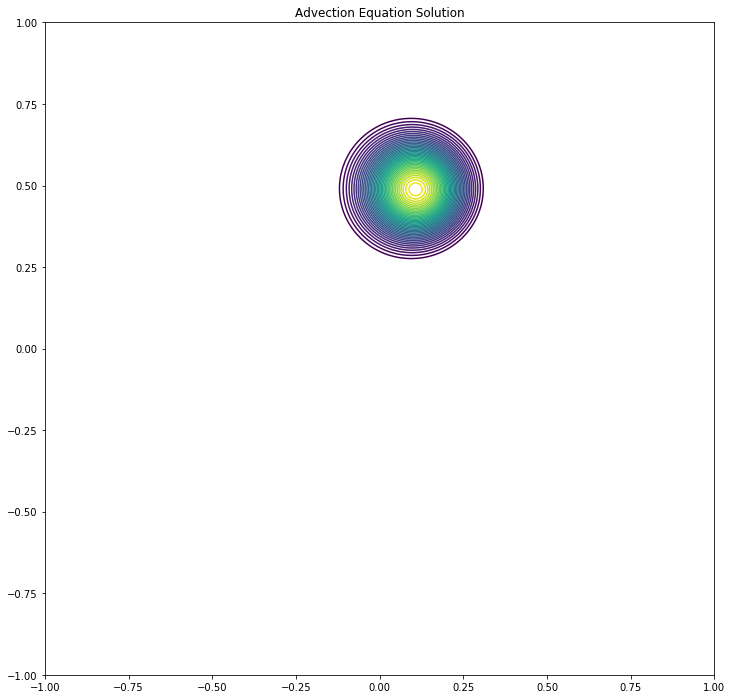

Budget error:  -6.7762635780344027125e-21 
qmin, qmax:  -1.0115725805993904161e-05 0.99617085391468703886
float128


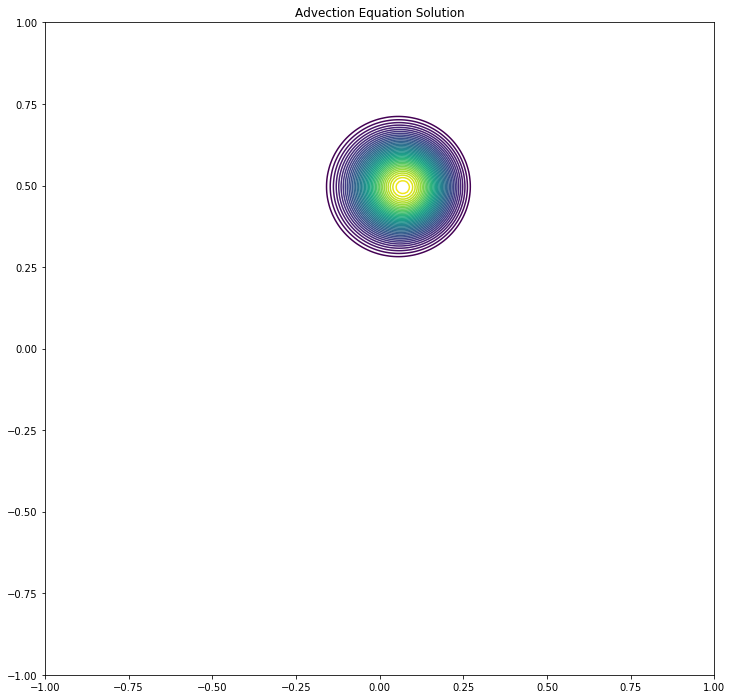

In [45]:
for t in range(nt):
    q = rk3(q,u,v,diffusion,dx,dy,order,dt)
    if t%20==0:
        bud = budget(q,dx,dy)
        print('Budget error: ',(bud-bud0),'\nqmin, qmax: ',q.min(),q.max())
        print(q.dtype)
        plotfig(Xc,Yc,q)
        plt.show()